In [1]:
%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

import plotly.express as px

import pandas as pd
import pandas_profiling
import numpy as np
from numpy import percentile
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
import random

import os, sys
import re
from tabulate import tabulate
import missingno as msno

from fastai.tabular import*

from umap import UMAP

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything()

plt.rc('font', size=18)        
plt.rc('axes', titlesize=22)      
plt.rc('axes', labelsize=18)      
plt.rc('xtick', labelsize=12)     
plt.rc('ytick', labelsize=12)     
plt.rc('legend', fontsize=12)   



pd.options.mode.chained_assignment = None
pd.options.display.max_seq_items = 500
pd.options.display.max_rows = 500
pd.set_option('display.float_format', lambda x: '%.5f' % x)

Populating the interactive namespace from numpy and matplotlib


In [0]:
# reducing memory for now, we check later if this affects our models
def reduce_memory(df_):
    for col in df_.columns:
        if df_[col].dtype =='float64': df_[col] = df_[col].astype('float32')
        if df_[col].dtype =='int64': df_[col] = df_[col].astype('int32')
    return df_


# This functions is based on this cool script: 
# https://www.kaggle.com/bwilsonkg/column-statistics
def show_stats(data_frame):
    stats_column_names = ('column', 'dtype', 'nan_cts', 'nan_perc', 'val_cts',
                          'min', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis')
    stats_array = []
    length_df = len(data_frame)
    for column_name in sorted(data_frame.columns):
        col = data_frame[column_name]
        if is_numeric_column(col):
            nan_perc = 100 / length_df * col.isna().sum()
            stats_array.append(
                [column_name, col.dtype, col.isna().sum(), nan_perc, len(col.value_counts()),
                 col.min(), col.max(), col.mean(), col.median(), col.std(), col.skew(),
                 col.kurtosis()])
        else:
            nan_perc = 100 / length_df * col.isna().sum()
            stats_array.append(
                [column_name, col.dtype, col.isna().sum(), nan_perc, len(col.value_counts()),
                 0, 0, 0, 0, 0, 0, 0])
    stats_df = pd.DataFrame(data=stats_array, columns=stats_column_names)
    with pd.option_context('display.float_format', lambda x: '%.1f' % x):
        display(stats_df)
        
def of_type(stats_data_frame, column_dtype):
    return stats_data_frame[stats_data_frame['dtype'] == column_dtype]

def sort(data_frame, column_name, ascending=False):
    return data_frame.sort_values(column_name, ascending=ascending)

def is_numeric_column(df_column):
    numeric_types = (np.int16, np.float16, np.int32, np.float32,
                     np.int64, np.float64)
    return df_column.dtype in numeric_types

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_df = reduce_memory(pd.read_csv('/content/drive/My Drive/ASHRAE_data', compression='zip'))

In [0]:
# calculate normal and extreme upper and lower cut off
for feature in train_df.select_dtypes("number").columns:

    cut_off = train_df[feature].std() * 3
    lower   = train_df[feature].mean() - cut_off 
    upper   = train_df[feature].mean() + cut_off
    df_lower = train_df[train_df[feature] < lower]
    df_upper = train_df[train_df[feature] > upper]
    
    if df_lower.shape[0] != 0 or df_upper.shape[0] != 0:
        print(f"{feature}")
        print(f"lower bound: {lower:.2f}\nupper bound: {upper:.2f}")
        if df_lower.shape[0] != 0:
            display(train_df[train_df[feature] < lower].sort_values(feature))
        if df_upper.shape[0] != 0:
            display(train_df[train_df[feature] > upper].sort_values(feature))
        print()

meter_reading
lower bound: -457589.75
upper bound: 461824.00


Unnamed: 0  building_id  ...  wind_direction wind_speed
14531339    14531339          778  ...        50.00000    6.20000
16078422    16078422          778  ...         0.00000    0.00000
15947163    15947163          778  ...       190.00000    3.60000
15599395    15599395          778  ...        60.00000    1.50000
14983126    14983126          778  ...       110.00000    3.60000
...              ...          ...  ...             ...        ...
8905140      8905140         1099  ...       140.00000    3.60000
17286421    17286421         1099  ...       190.00000    2.10000
8736187      8736187         1099  ...       140.00000    6.20000
8738539      8738539         1099  ...       130.00000    5.10000
8907488      8907488         1099  ...        50.00000    6.20000

[3750 rows x 17 columns]


square_feet
lower bound: -243644.35
upper bound: 459210.31


Unnamed: 0  building_id  ...  wind_direction wind_speed
2701863      2701863          519  ...       150.00000    6.20000
3986920      3986920          519  ...        20.00000    1.50000
2184080      2184080          519  ...         0.00000    0.00000
14942754    14942754          519  ...        80.00000    6.70000
10735430    10735430          519  ...       280.00000    5.10000
...              ...          ...  ...             ...        ...
994616        994616          869  ...       310.00000    3.10000
15226348    15226348          869  ...       100.00000    4.10000
5930532      5930532          869  ...       160.00000    1.50000
9134521      9134521          869  ...       230.00000    2.60000
4025253      4025253          869  ...       230.00000    2.10000

[445224 rows x 17 columns]


floor_count
lower bound: -7.84
upper bound: 16.21


Unnamed: 0  building_id  ...  wind_direction wind_speed
20214781    20214781          802  ...        70.00000    4.10000
5843791      5843791          802  ...       310.00000    6.70000
14044584    14044584          802  ...       210.00000    4.60000
14046936    14046936          802  ...       190.00000    2.10000
14046937    14046937          802  ...       190.00000    2.10000
...              ...          ...  ...             ...        ...
5836755      5836755          799  ...       330.00000    5.10000
14051636    14051636          799  ...       180.00000    0.50000
14051635    14051635          799  ...       180.00000    0.50000
5839096      5839096          799  ...       310.00000    6.20000
4808288      4808288          799  ...       210.00000    5.10000

[79007 rows x 17 columns]


air_temperature
lower bound: -16.85
upper bound: 48.83


Unnamed: 0  building_id  ...  wind_direction wind_speed
19460045    19460045         1126  ...       220.00000    2.10000
19460030    19460030         1117  ...       220.00000    2.10000
19460031    19460031         1118  ...       220.00000    2.10000
19460032    19460032         1119  ...       220.00000    2.10000
19460033    19460033         1119  ...       220.00000    2.10000
...              ...          ...  ...             ...        ...
3227799      3227799          798  ...       290.00000    1.50000
3227798      3227798          798  ...       290.00000    1.50000
3227797      3227797          798  ...       290.00000    1.50000
3227808      3227808          801  ...       290.00000    1.50000
2284252      2284252          803  ...       320.00000    6.20000

[83178 rows x 17 columns]


dew_temperature
lower bound: -22.79
upper bound: 38.28


Unnamed: 0  building_id  ...  wind_direction wind_speed
2390128     2390128         1031  ...       310.00000    5.70000
2389680     2389680          799  ...       310.00000    5.70000
2389681     2389681          799  ...       310.00000    5.70000
2389682     2389682          800  ...       310.00000    5.70000
2389683     2389683          800  ...       310.00000    5.70000
...             ...          ...  ...             ...        ...
1002195     1002195         1206  ...         0.00000    0.00000
1002196     1002196         1206  ...         0.00000    0.00000
1002197     1002197         1207  ...         0.00000    0.00000
1002191     1002191         1203  ...         0.00000    0.00000
499917       499917         1069  ...       310.00000    6.20000

[87383 rows x 17 columns]


precip_depth_1_hr
lower bound: -21.61
upper bound: 23.20


Unnamed: 0  building_id  ...  wind_direction wind_speed
4612832     4612832         1028  ...       320.00000    5.70000
2549083     2549083          800  ...       320.00000    5.10000
2549084     2549084          800  ...       320.00000    5.10000
2549085     2549085          801  ...       320.00000    5.10000
2549086     2549086          801  ...       320.00000    5.10000
...             ...          ...  ...             ...        ...
4415828     4415828          103  ...        50.00000    1.50000
4415827     4415827          102  ...        50.00000    1.50000
4415826     4415826          101  ...        50.00000    1.50000
4415824     4415824           99  ...        50.00000    1.50000
4416753     4416753          813  ...        50.00000    1.50000

[149240 rows x 17 columns]


sea_level_pressure
lower bound: 994.90
upper bound: 1037.27


Unnamed: 0  building_id  ...  wind_direction wind_speed
2111178      2111178         1057  ...       220.00000   11.00000
2111172      2111172         1051  ...       220.00000   11.00000
2111173      2111173         1052  ...       220.00000   11.00000
2111174      2111174         1053  ...       220.00000   11.00000
2111175      2111175         1054  ...       220.00000   11.00000
...              ...          ...  ...             ...        ...
5175074      5175074         1357  ...         0.00000    0.00000
5175073      5175073         1356  ...         0.00000    0.00000
5175072      5175072         1355  ...         0.00000    0.00000
2017660      2017660          155  ...       190.00000   12.40000
18328195    18328195         1221  ...       130.00000    6.70000

[88598 rows x 17 columns]

Unnamed: 0  building_id  ...  wind_direction wind_speed
20105198    20105198          107  ...       350.00000    0.50000
18916144    18916144          909  ...       360.00000    3.60000
18916145    18916145          910  ...       360.00000    3.60000
18916146    18916146          910  ...       360.00000    3.60000
18916147    18916147          910  ...       360.00000    3.60000
...              ...          ...  ...             ...        ...
19982347    19982347          131  ...        40.00000    1.00000
19982346    19982346          130  ...        40.00000    1.00000
19982345    19982345          129  ...        40.00000    1.00000
19982358    19982358          140  ...        40.00000    1.00000
19982359    19982359          141  ...        40.00000    1.00000

[64281 rows x 17 columns]


wind_speed
lower bound: -3.42
upper bound: 10.17


Unnamed: 0  building_id  ...  wind_direction wind_speed
2775790      2775790          121  ...       250.00000   10.30000
17817055    17817055         1140  ...       330.00000   10.30000
17817056    17817056         1141  ...       330.00000   10.30000
17817057    17817057         1142  ...       330.00000   10.30000
17817058    17817058         1142  ...       330.00000   10.30000
...              ...          ...  ...             ...        ...
1737964      1737964         1042  ...       250.00000   19.00000
1737963      1737963         1041  ...       250.00000   19.00000
1737962      1737962         1040  ...       250.00000   19.00000
1747186      1747186         1041  ...       250.00000   19.00000
1737967      1737967         1045  ...       250.00000   19.00000

[191356 rows x 17 columns]

In [0]:
missing = [(c, train_df[c].isna().mean()*100) for c in train_df]
missing = pd.DataFrame(missing, columns=["feature", "percentage"])
missing["count"] = [train_df[c].isna().sum() for c in train_df]
missing = missing[missing.percentage > 0]
display(missing.sort_values("percentage", ascending=False))

feature  percentage     count
9          floor_count    82.65277  16709167
8           year_built    59.99003  12127645
11      cloud_coverage    43.65513   8825365
13   precip_depth_1_hr    18.54474   3749023
15      wind_direction     7.16779   1449048
14  sea_level_pressure     6.09252   1231669
16          wind_speed     0.71070    143676
12     dew_temperature     0.49535    100140
10     air_temperature     0.47812     96658

In [17]:
## Descriptive Statistics
show_stats(train_df)
display(train_df.sample(5).head())

column    dtype   nan_cts  ...     stdev  skew  kurtosis
0           Unnamed: 0    int32         0  ... 5835885.5   0.0      -1.2
1      air_temperature  float32     96658  ...      10.8  -0.4      -0.0
2          building_id    int32         0  ...     426.9  -0.3      -1.2
3       cloud_coverage  float32   8825365  ...       2.4   1.2       0.4
4      dew_temperature  float32    100140  ...      10.0  -0.4      -0.3
5          floor_count  float32  16709167  ...       4.0   2.5       8.4
6                meter    int32         0  ...       0.9   1.2       0.2
7        meter_reading  float32         0  ...  153215.9 104.8   11671.9
8    precip_depth_1_hr  float32   3749023  ...       7.4  18.9     507.9
9          primary_use   object         0  ...       0.0   0.0       0.0
10  sea_level_pressure  float32   1231669  ...      54.2  -0.1       1.1
11             site_id    int32         0  ...       5.1  -0.0      -1.5
12         square_feet    int32         0  ...  117142.4   2.7      10.0
13           timestamp   object         0  ...       0.0   0.0       0.0
14      wind_direction  float32   1449048  ...     113.4  -0.1      -1.2
15          wind_speed  float32    143676  ...       2.3   0.8       1.2
16          year_built  float32  12127645  ...      71.2  -0.4      -0.7

[17 rows x 12 columns]

Unnamed: 0  building_id  ...  wind_direction wind_speed
11990877    11990877          774  ...         0.00000    0.00000
15256244    15256244          206  ...        90.00000    1.50000
18401495    18401495         1269  ...       100.00000    2.60000
15573710    15573710          951  ...         0.00000    0.00000
6515439      6515439          656  ...       300.00000    2.60000

[5 rows x 17 columns]

In [0]:
msno.matrix(train_df)

In [0]:
train_df = add_datepart(train_df, "timestamp", drop=False, time=True)

In [0]:
timeframes = {"month"   : train_df.timestamp.dt.month,
              "week"    : train_df.timestamp.dt.week, 
              "weekday" : train_df.timestamp.dt.weekday, 
              "hour"    : train_df.timestamp.dt.hour}

In [0]:
lb = LabelEncoder()
train_df.primary_use_lb = lb.fit_transform(train_df.primary_use)
train_df.primary_use_lb = train_df.primary_use_lb.astype("int32")
# sample 100k to avoid crashing of kernel
corr_raw = train_df.sample(100_000).drop(["timestamp", "primary_use"], axis=1).astype(float)

In [0]:
# adding some temporary time related features
corr_raw["quarter"] = train_df.timestamp.dt.quarter
corr_raw["quarter_start"] = train_df.timestamp.dt.is_quarter_start
corr_raw["quarter_end"] = train_df.timestamp.dt.is_quarter_end
corr_raw["month"] = train_df.timestamp.dt.month
corr_raw["month_start"] = train_df.timestamp.dt.is_month_start
corr_raw["month_end"] = train_df.timestamp.dt.is_month_end
corr_raw["week"] = train_df.timestamp.dt.week
corr_raw["dayofweek"] = train_df.timestamp.dt.dayofweek
corr_raw["weekend"] = corr_raw.dayofweek.apply(lambda x: True if x in [5, 6] else False)
corr_raw["day"] = train_df.timestamp.dt.day
corr_raw["hour"] = train_df.timestamp.dt.hour

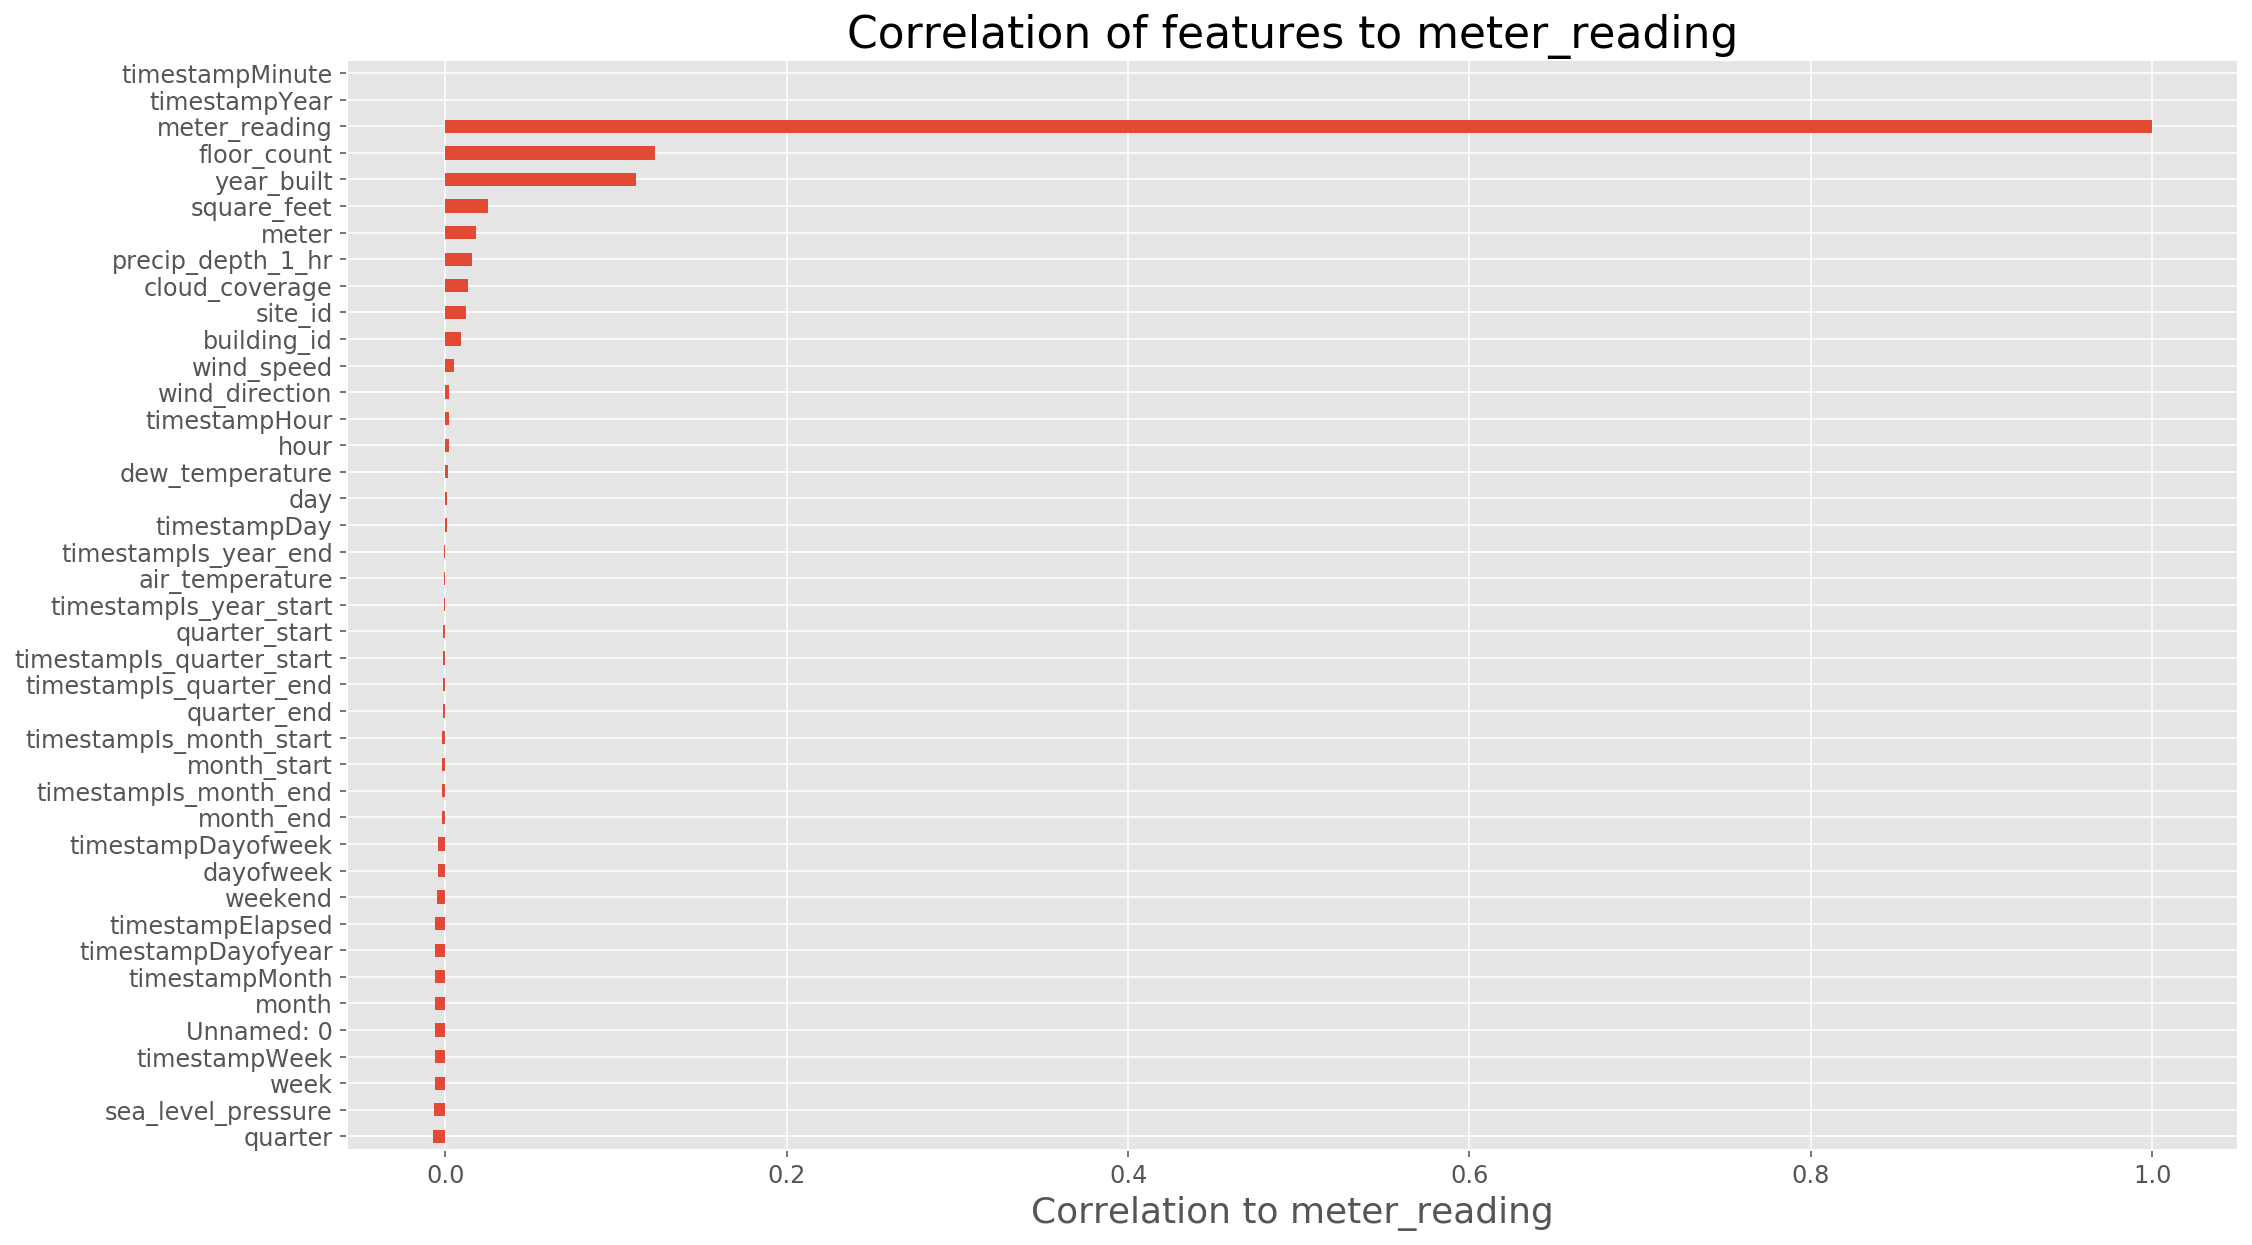

In [0]:
corr = corr_raw.corr()
plt.figure(figsize=(16,9));
corr["meter_reading"].sort_values(ascending=True)[:-1].plot(kind="barh")
plt.title("Correlation of features to meter_reading")
plt.xlabel("Correlation to meter_reading")
plt.tight_layout()
plt.show()

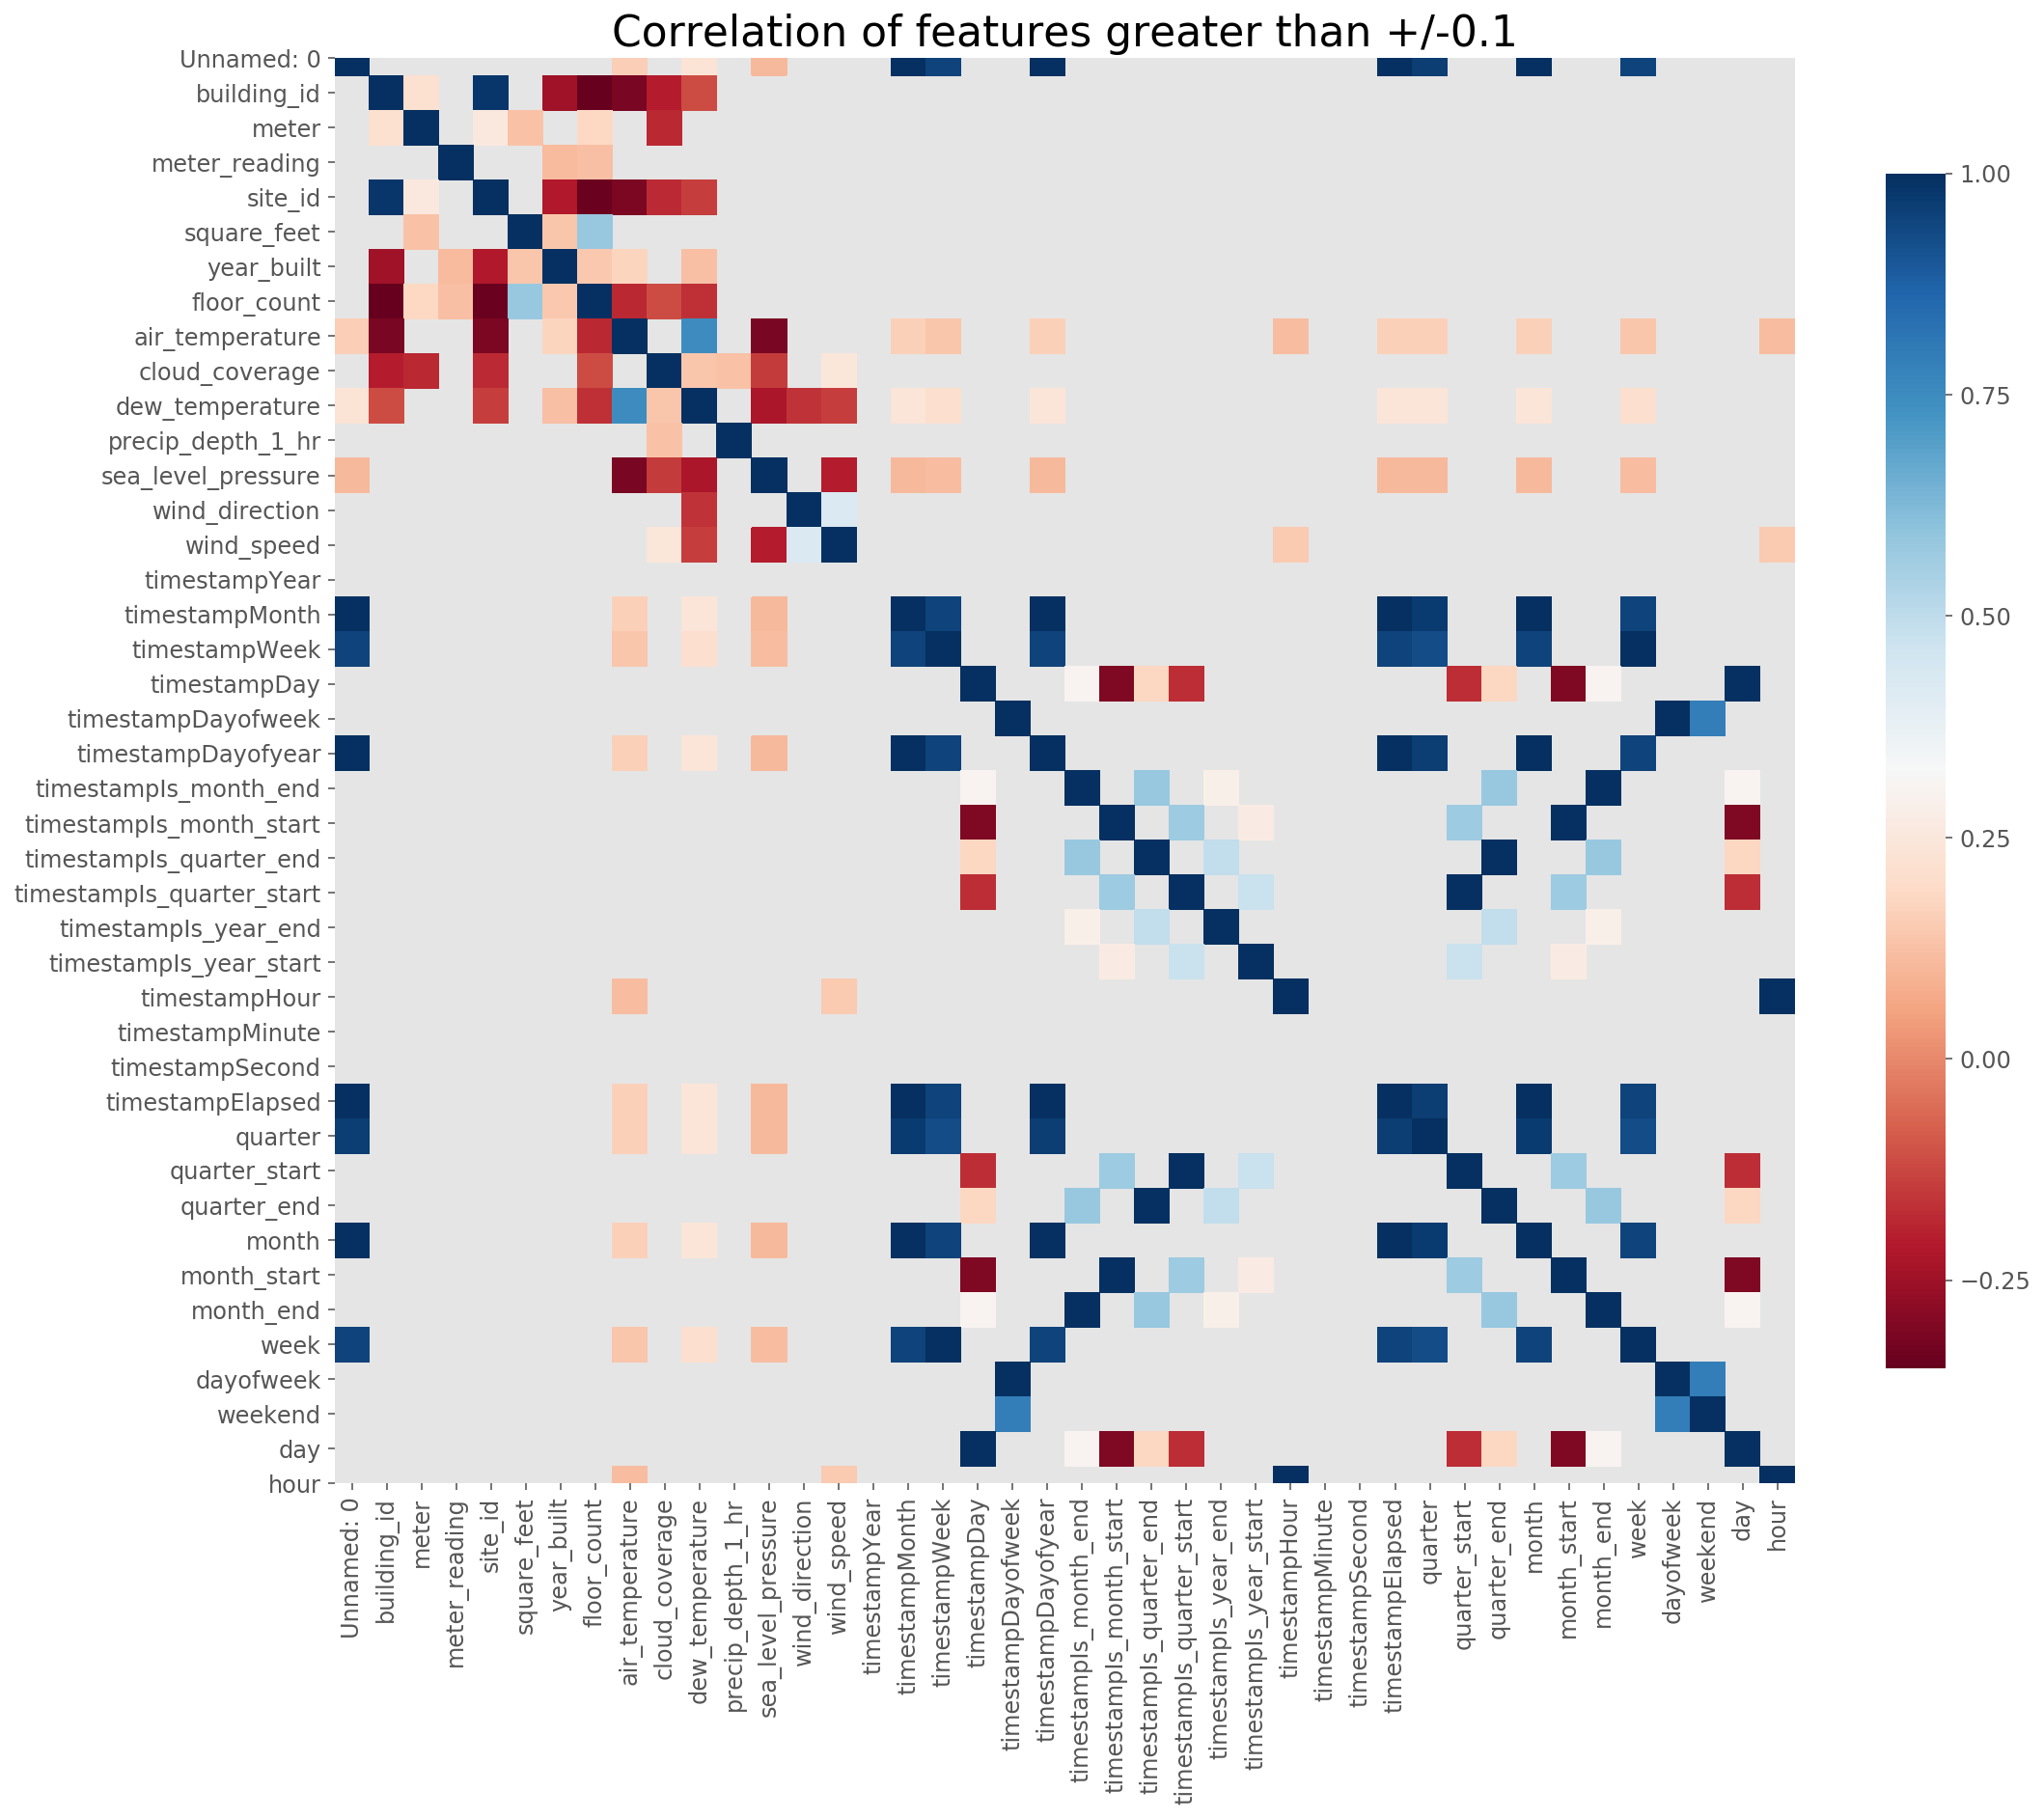

In [0]:
# get correlation among all features with pandas .corr() function
corr = corr_raw.corr()
# filter correlations less than 0.1
cut_off = 0.1
corr = corr[(corr > cut_off) | (corr < -cut_off)]

plt.subplots(figsize=(16,16));
sns.heatmap(corr, cmap="RdBu", square=True, annot=False, cbar_kws={"shrink": .6}, )
plt.title(f"Correlation of features greater than +/-{cut_off}")
plt.tight_layout()
plt.show()

In [0]:
print(train_df.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 33 columns):
Unnamed: 0                   20216100 non-null int64
building_id                  20216100 non-null int64
meter                        20216100 non-null int64
timestamp                    20216100 non-null datetime64[ns]
meter_reading                20216100 non-null float64
site_id                      20216100 non-null int64
primary_use                  20216100 non-null object
square_feet                  20216100 non-null int64
year_built                   8088455 non-null float64
floor_count                  3506933 non-null float64
air_temperature              20119442 non-null float64
cloud_coverage               11390735 non-null float64
dew_temperature              20115960 non-null float64
precip_depth_1_hr            16467077 non-null float64
sea_level_pressure           18984431 non-null float64
wind_direction               18767052 non-null float64
wind_speed 

In [0]:
## Define meter types
energy_types_dict = {0: "electricity", 1: "chilledwater", 2: "steam", 3: "hotwater"}
energy_types      = ['electricity', 'chilledwater', 'steam', 'hotwater']

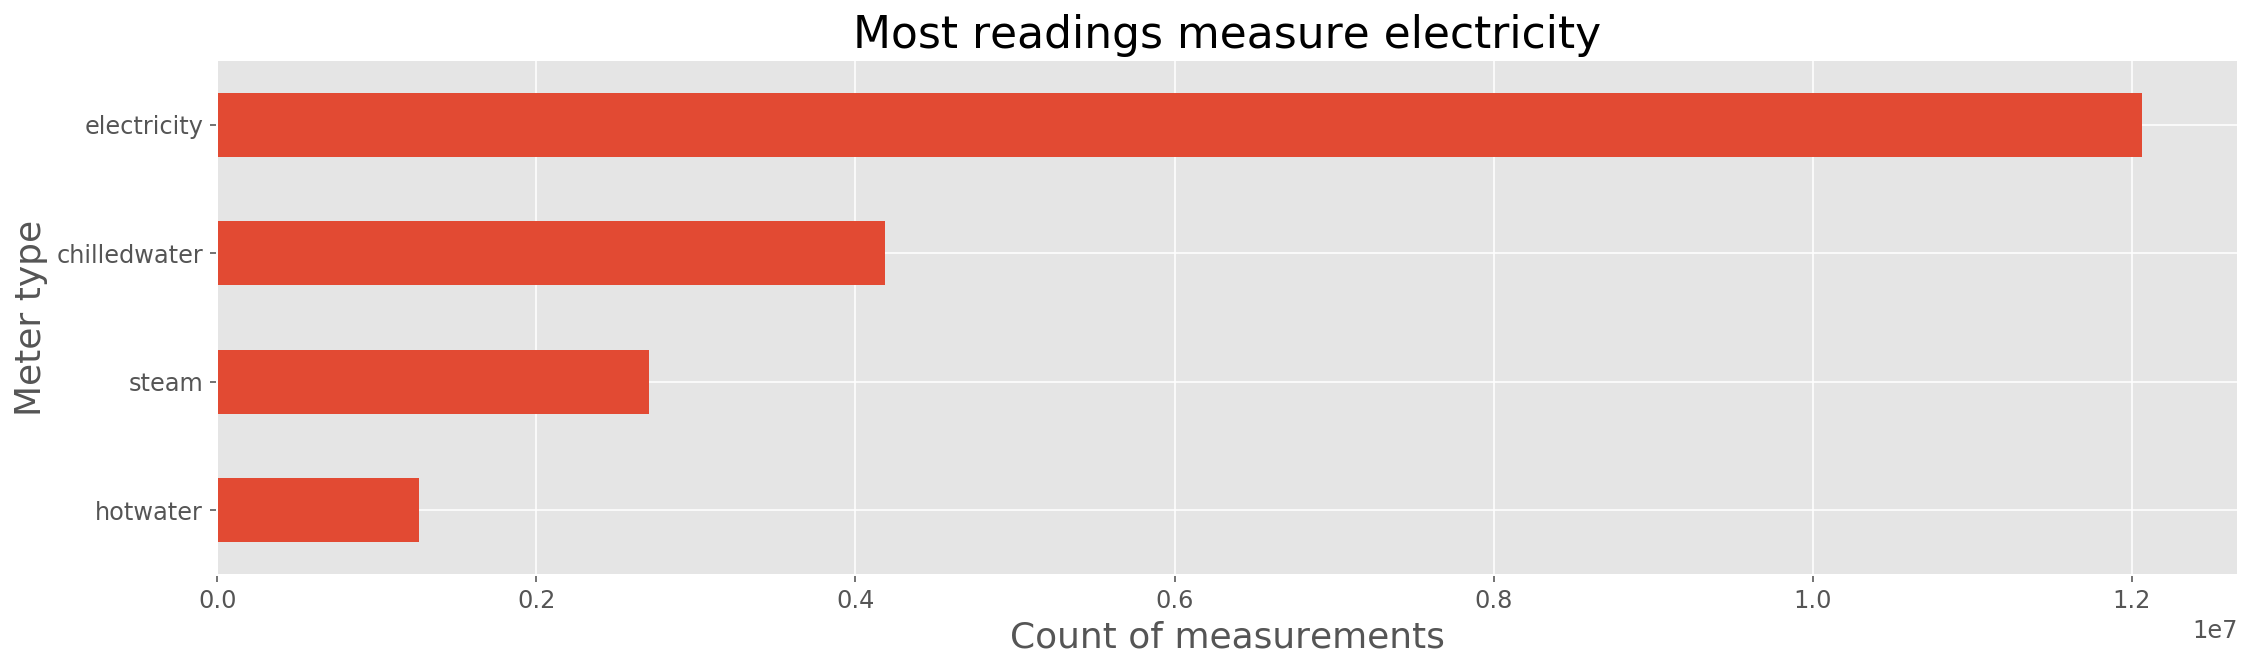

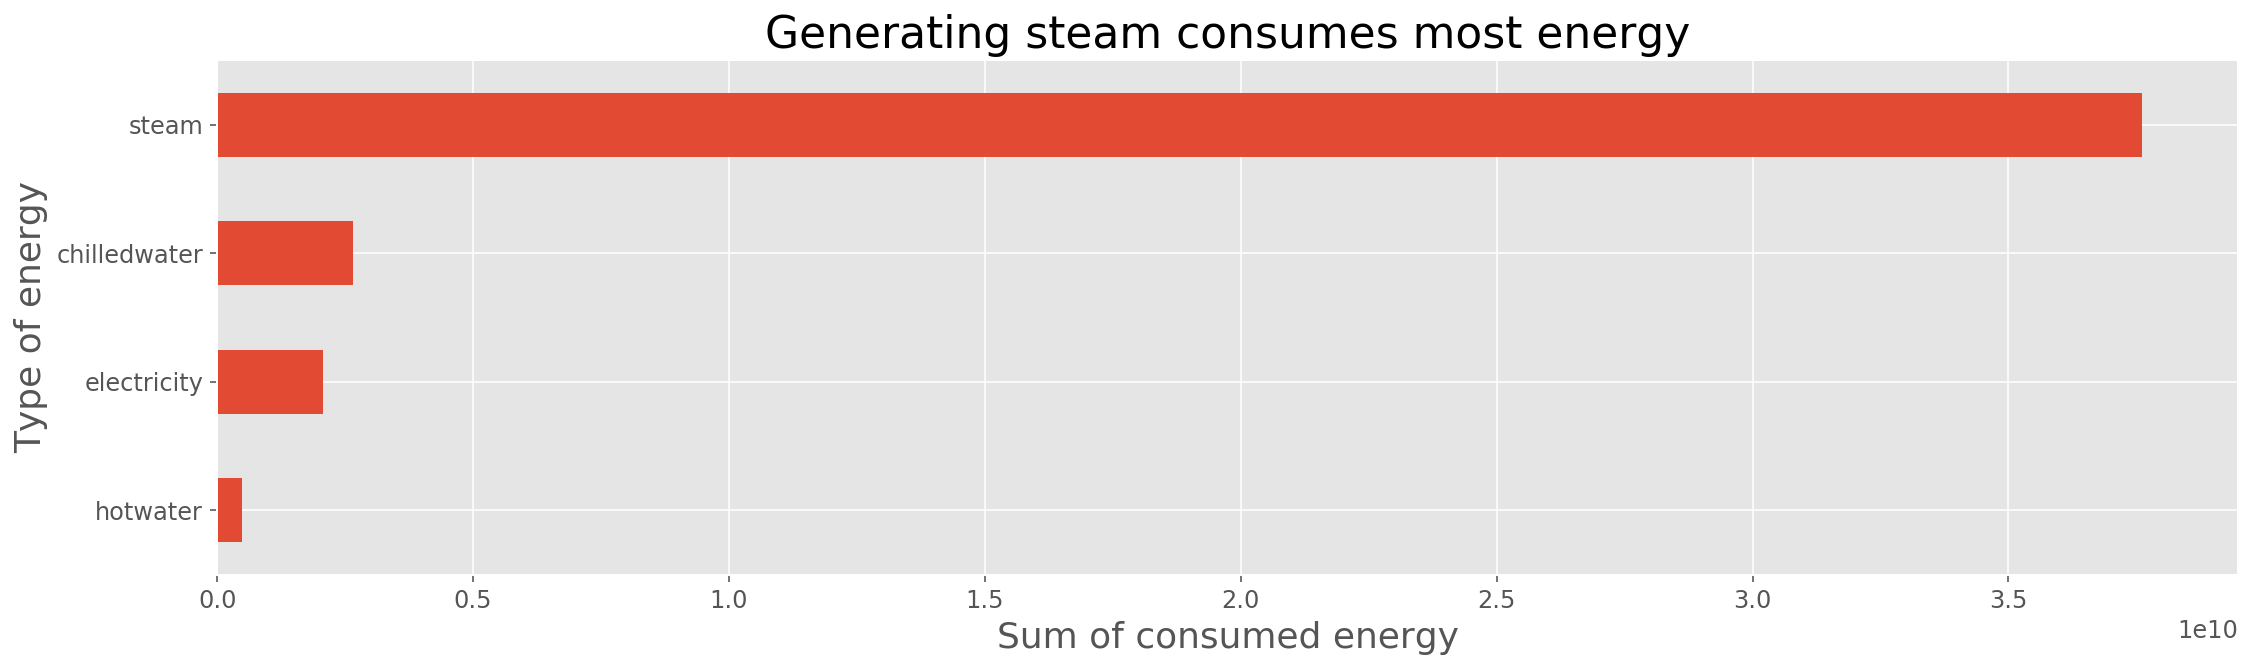

In [0]:
## Meter reading and type of meter
plt.figure(figsize=(16,5))
tmp_df = train_df.meter.value_counts()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Most readings measure electricity")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
tmp_df = train_df.groupby("meter").meter_reading.sum()
tmp_df.index = energy_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Steam consumes most energy")
plt.xlabel("Sum of consumed energy")
plt.ylabel(f"Type of energy")
plt.tight_layout()
plt.show()

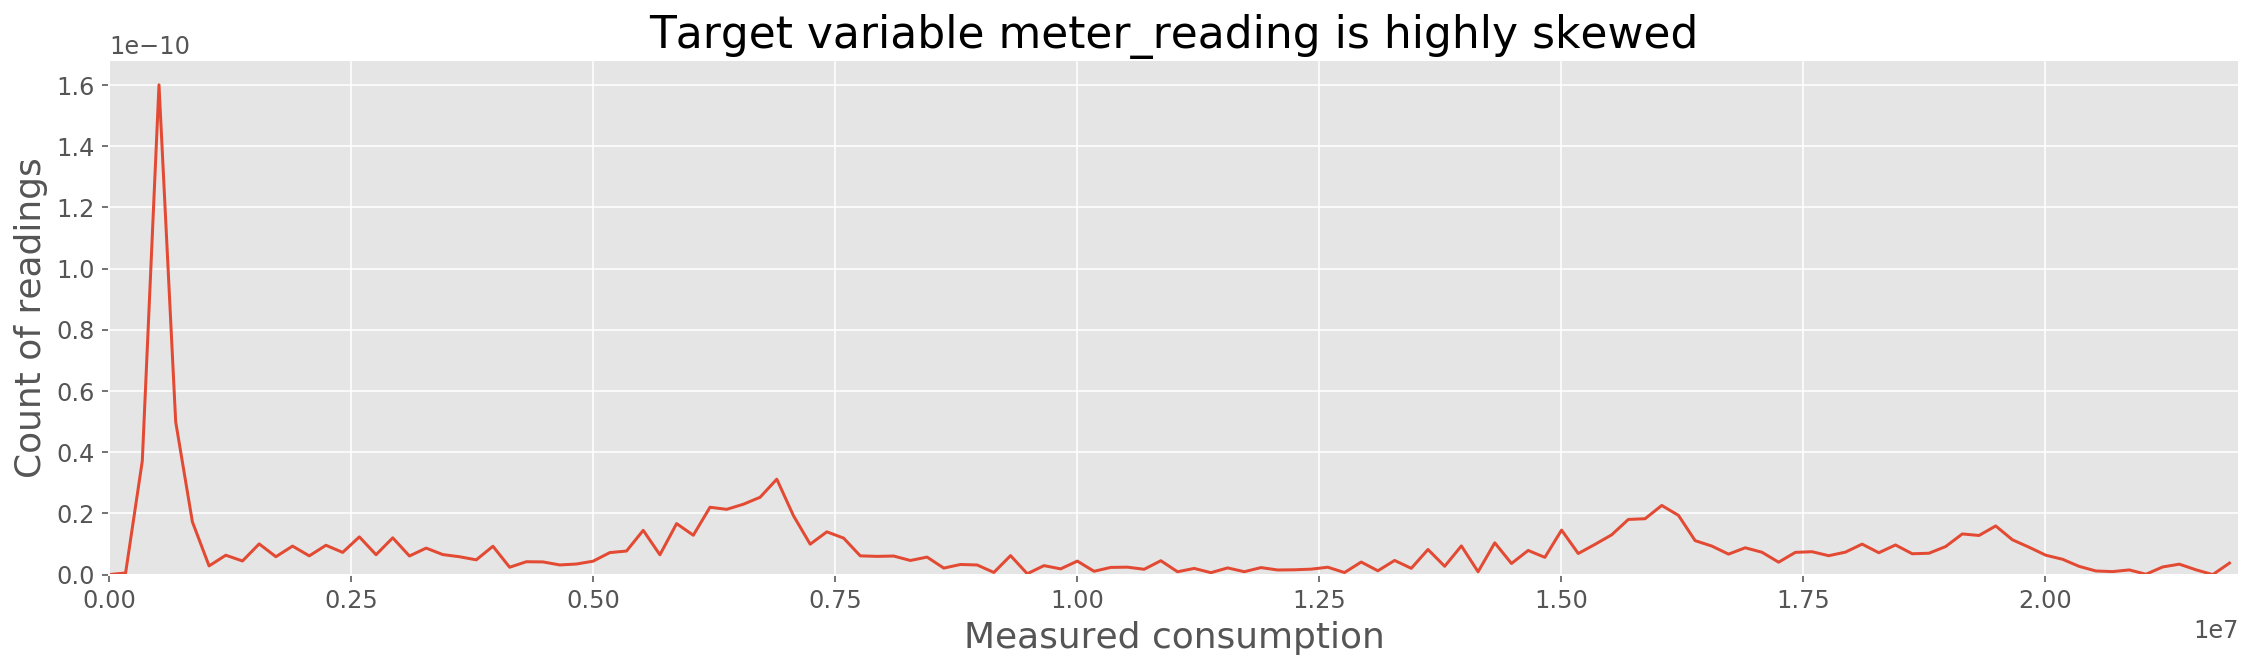

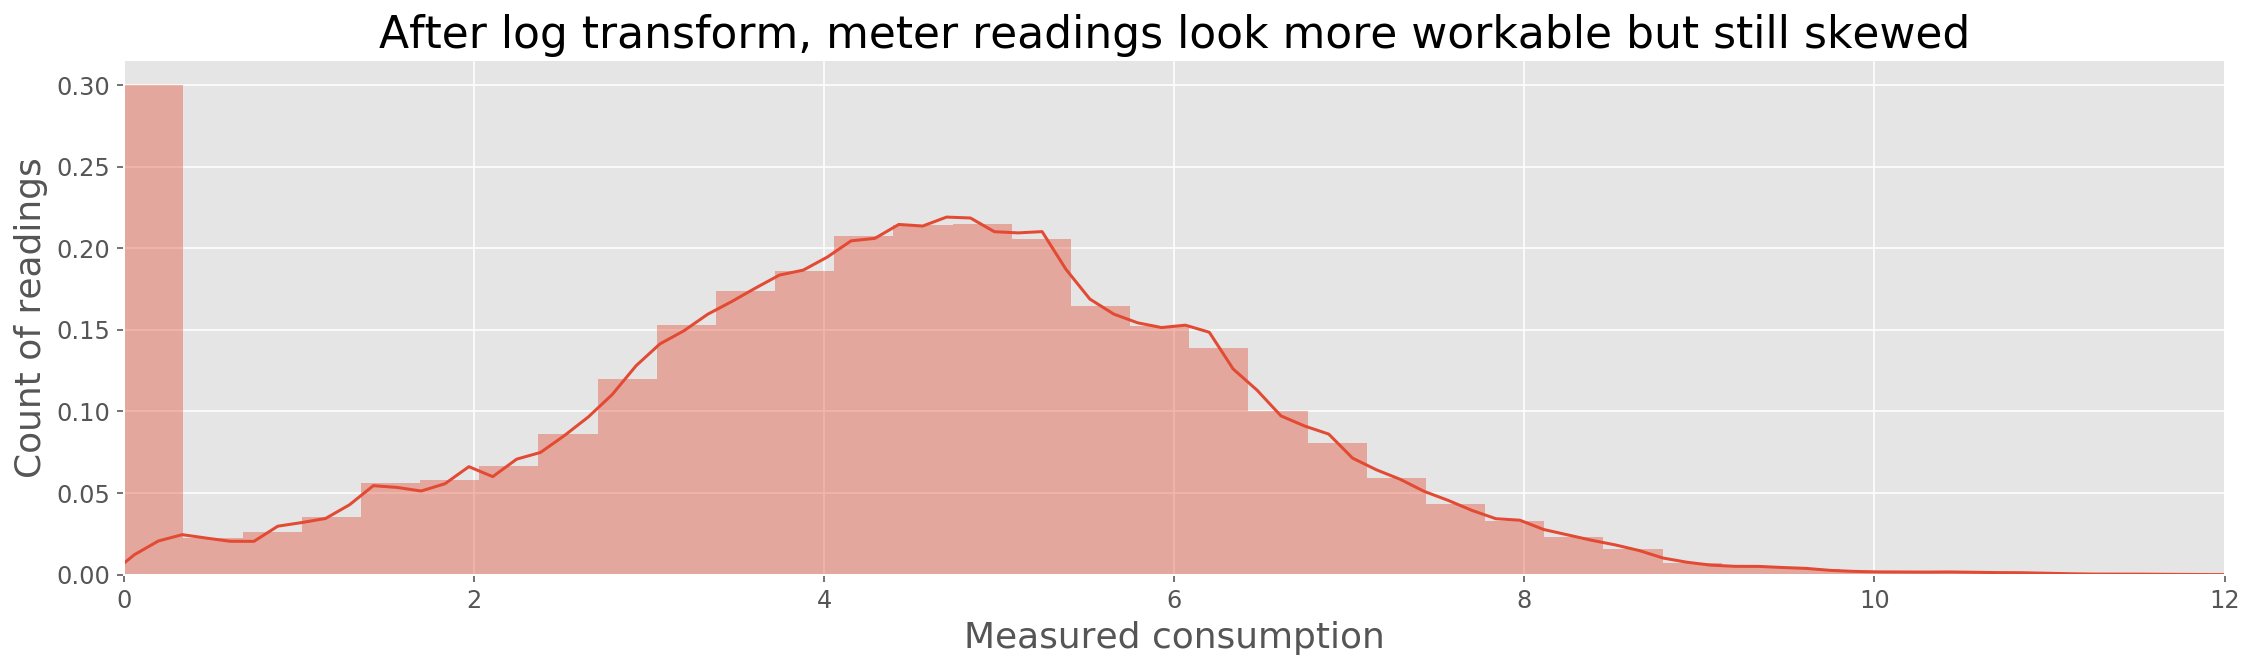

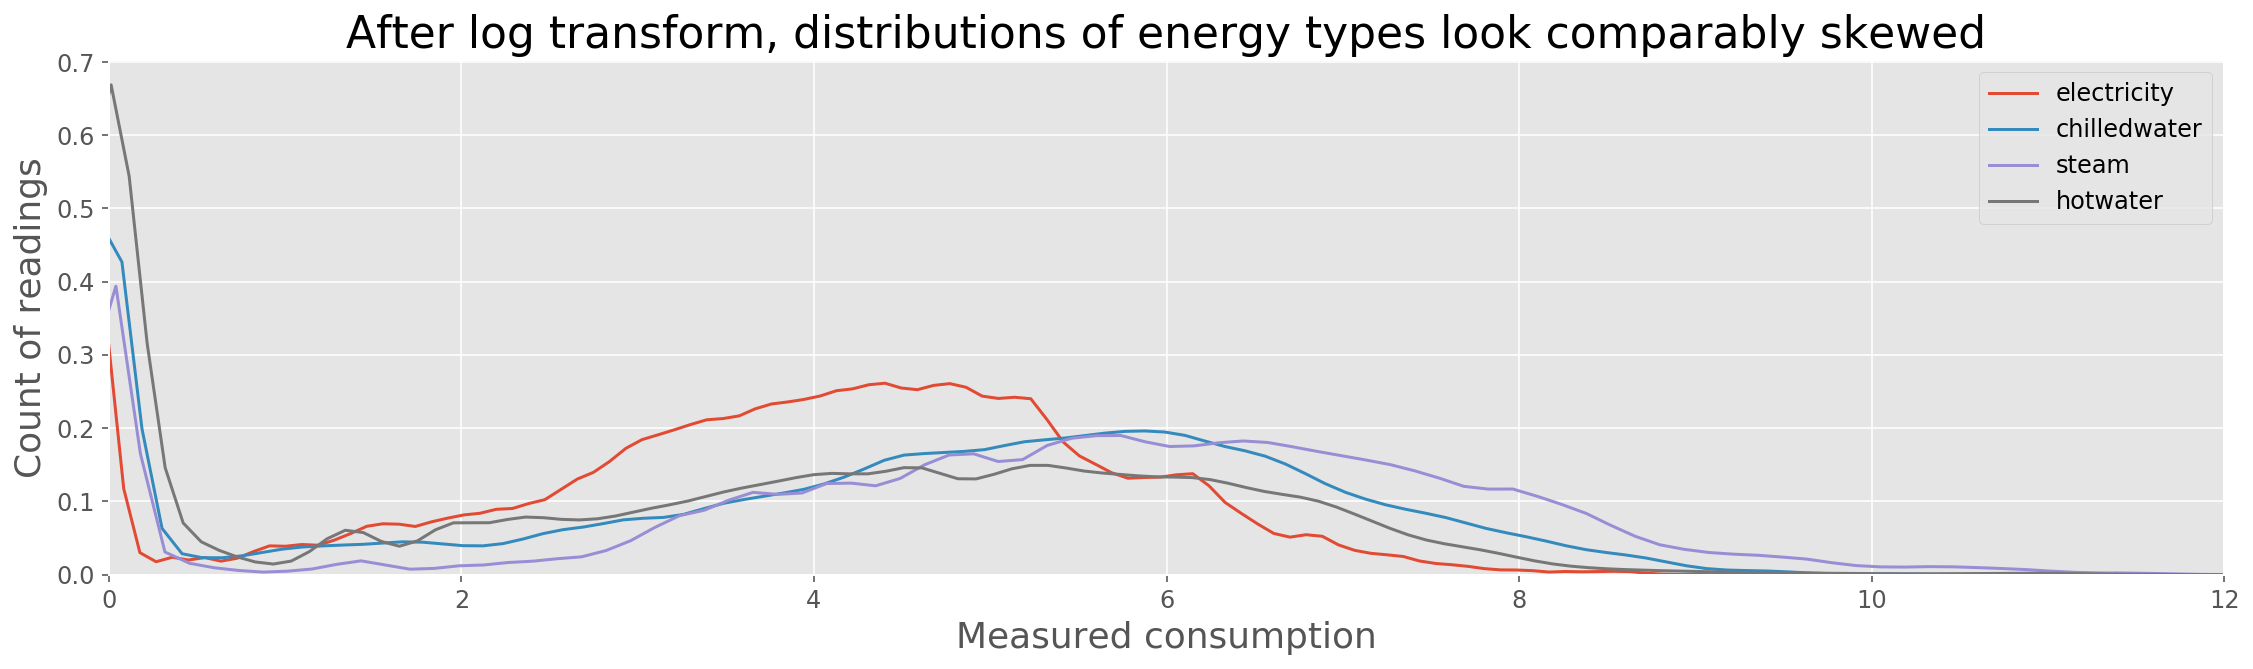

In [0]:
## Meter reading (target) distribution
plt.figure(figsize=(16,5))
sns.distplot(train_df.meter_reading, hist=False)
plt.title(f"Meter reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Consumption")
plt.xlim(0, train_df.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
sns.distplot(np.log1p(train_df.meter_reading))
plt.title(f"Log transform, meter readings look more workable")
plt.ylabel("Count of readings")
plt.xlabel(f"Consumption")
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,5))
for idx in range(0,4):
    sns.distplot(np.log1p(train_df[train_df.meter==idx].meter_reading), hist=False, label=energy_types[idx])
plt.title(f"Distributions of energy types log transform")
plt.ylabel("Count of readings")
plt.xlabel(f"Consumption")
plt.legend()
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

In [0]:
plt.figure(figsize=(16,7))
_ = stats.probplot(train_df['meter_reading'], plot=plt)
plt.title("Probability plot for meter reading")
plt.show()

In [0]:
plt.figure(figsize=(16,7))
_ = stats.probplot(np.log(train_df['meter_reading']), plot=plt)
plt.title("Log transformed still skewed")
plt.show()

In [0]:
## Checking building with high consumption
train_df.groupby("building_id").meter_reading.sum().sort_values(ascending=False)[:5]

building_id
1099   33506195415.40701
778      440411443.01820
1168     428634168.39040
1197     390400248.10460
1159     314241460.21400
Name: meter_reading, dtype: float64

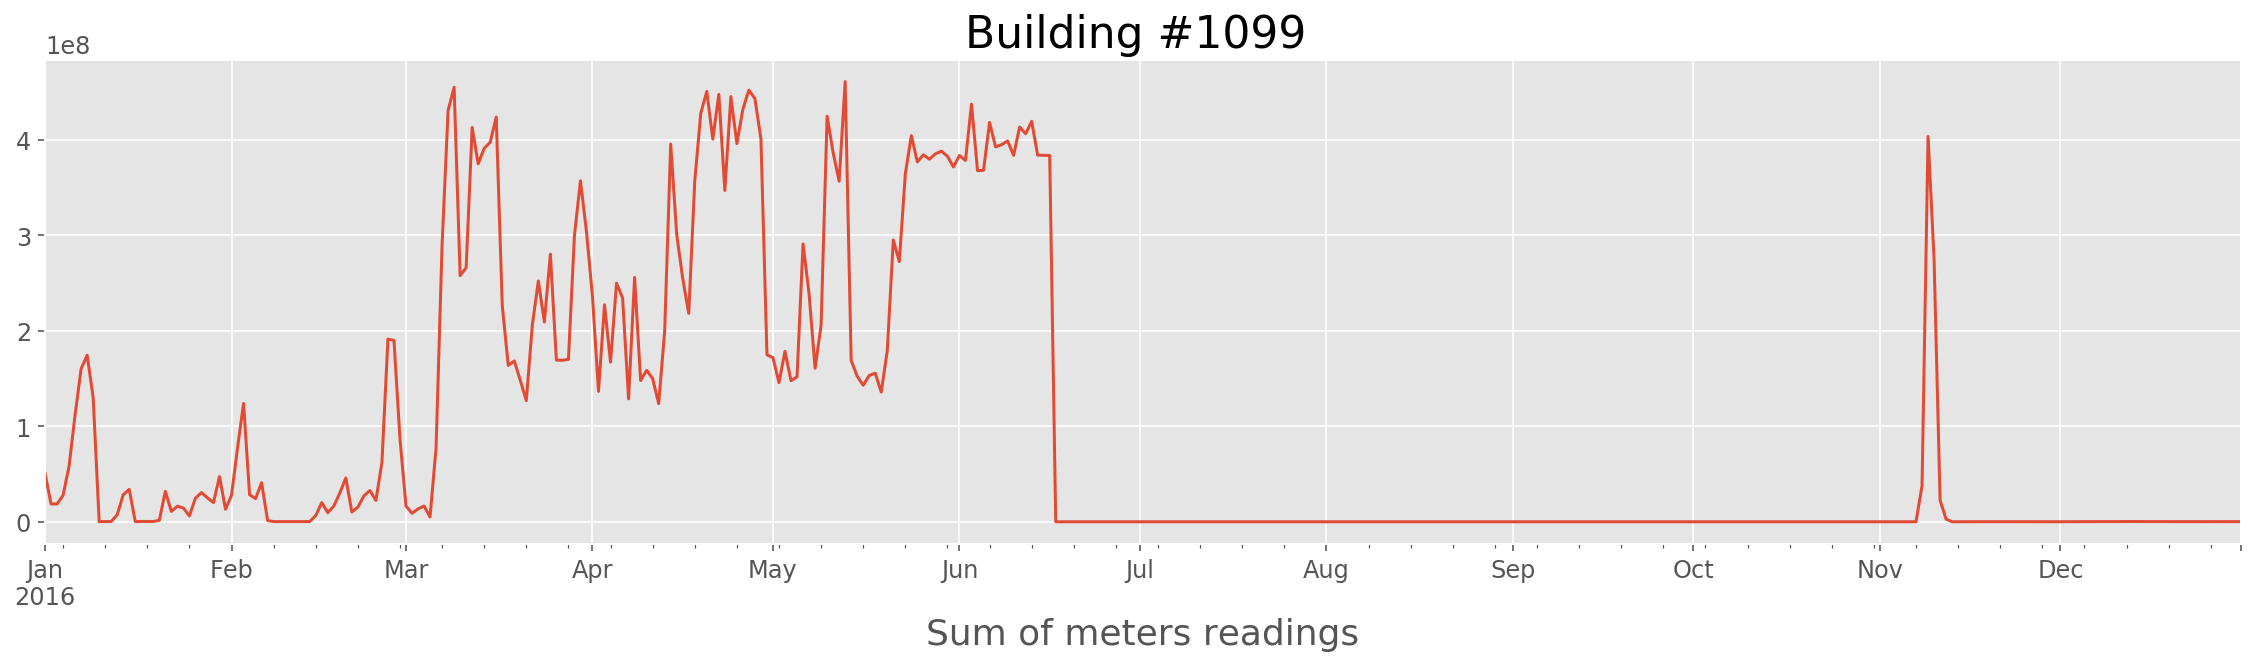

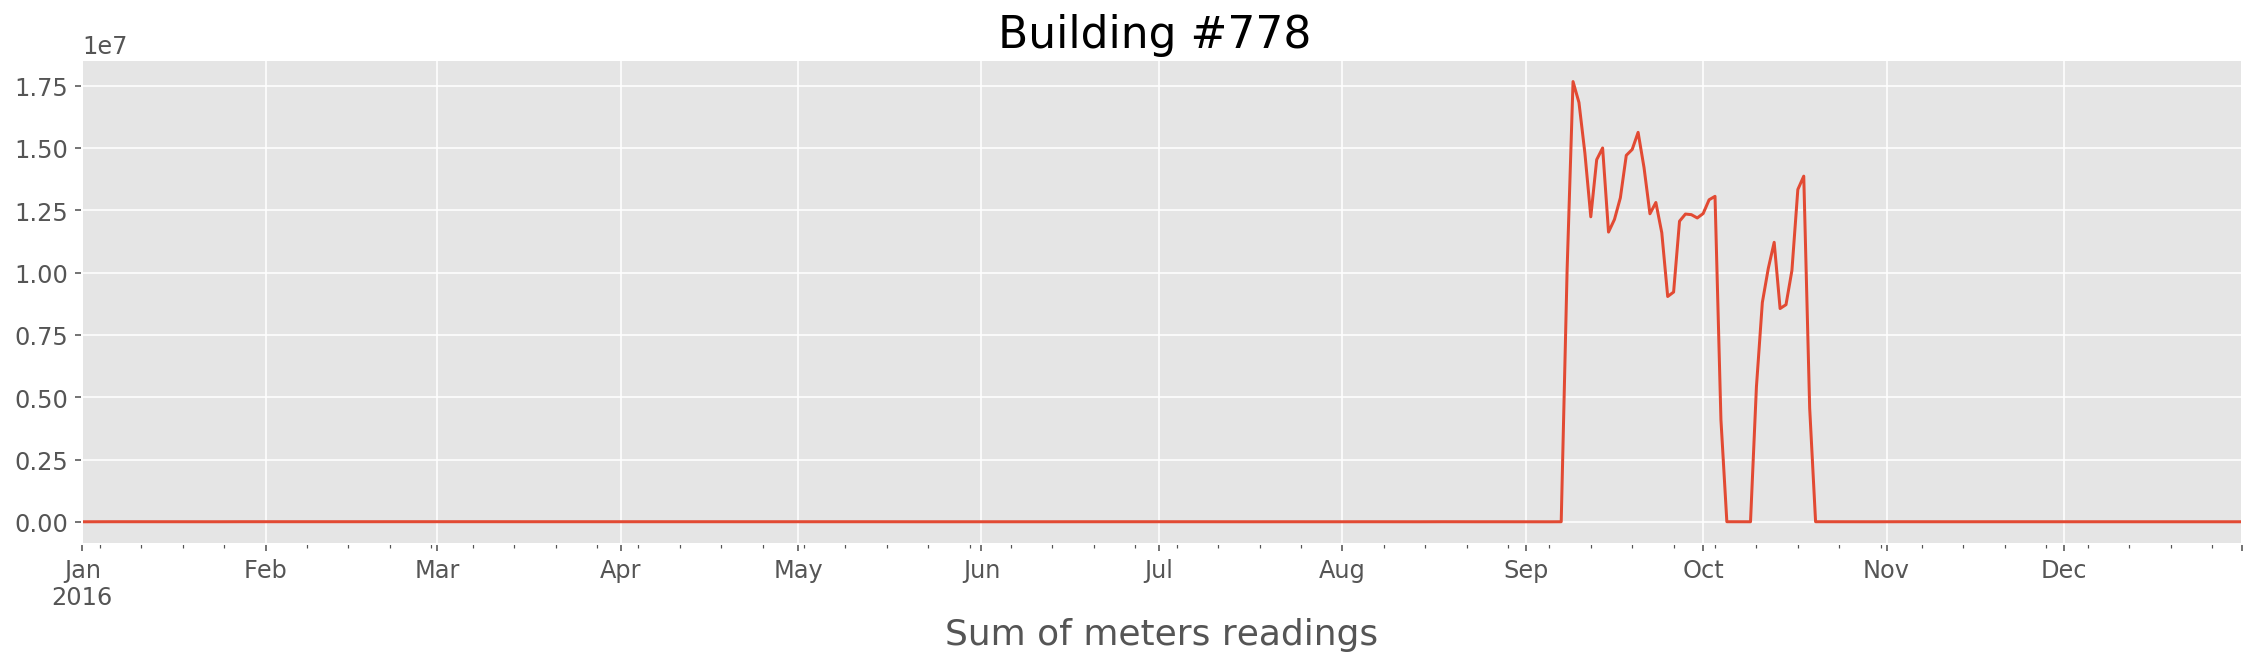

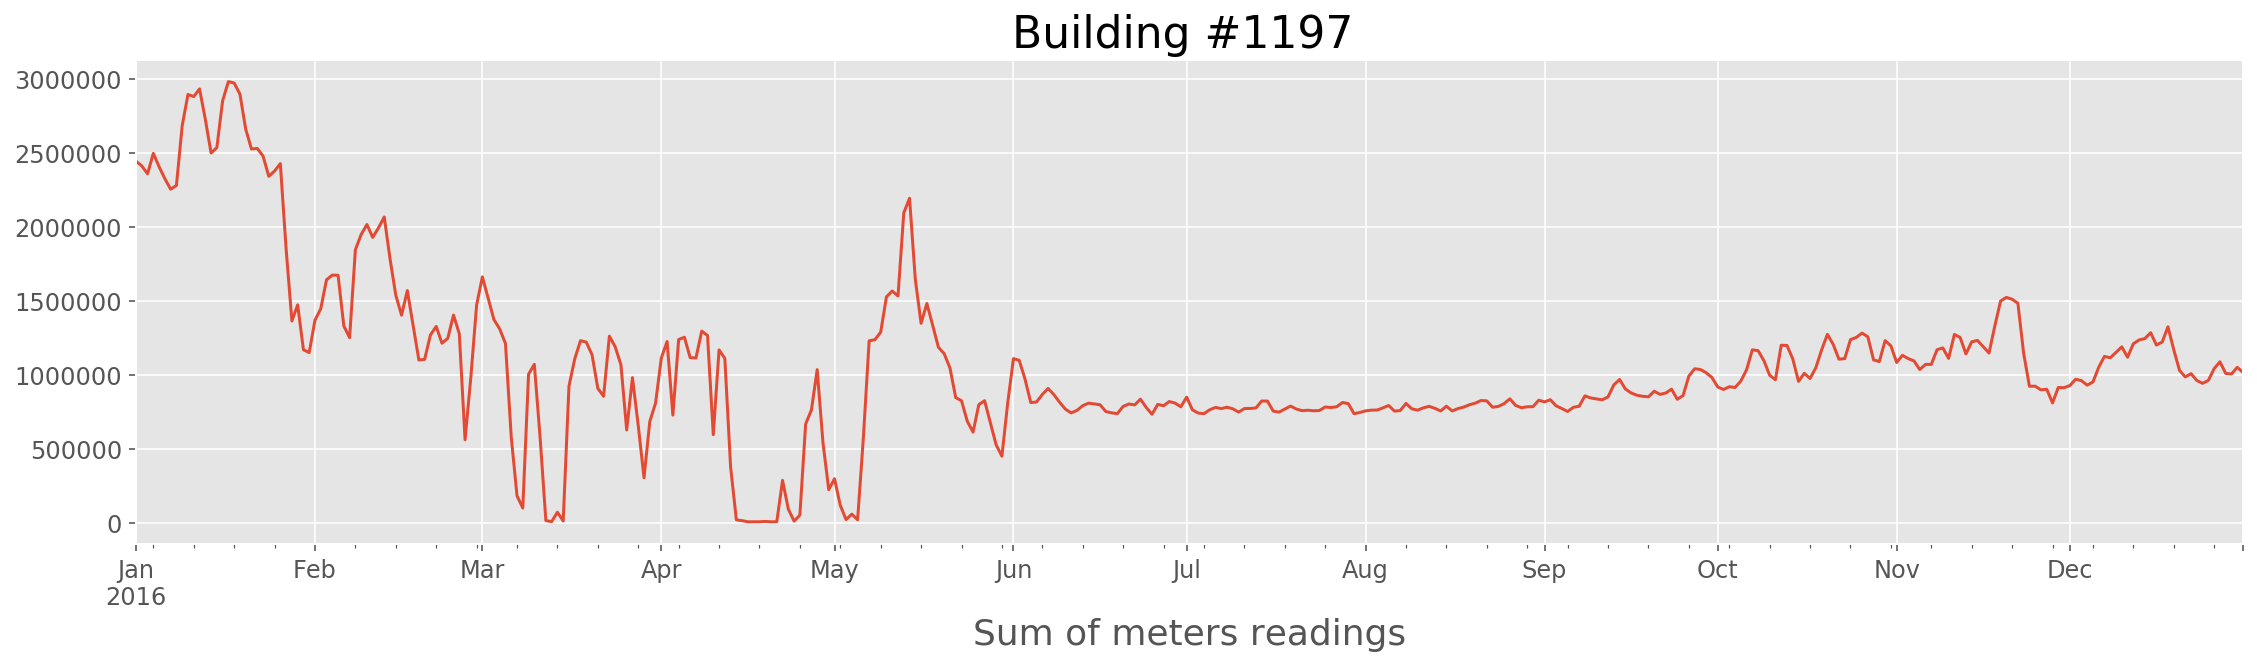

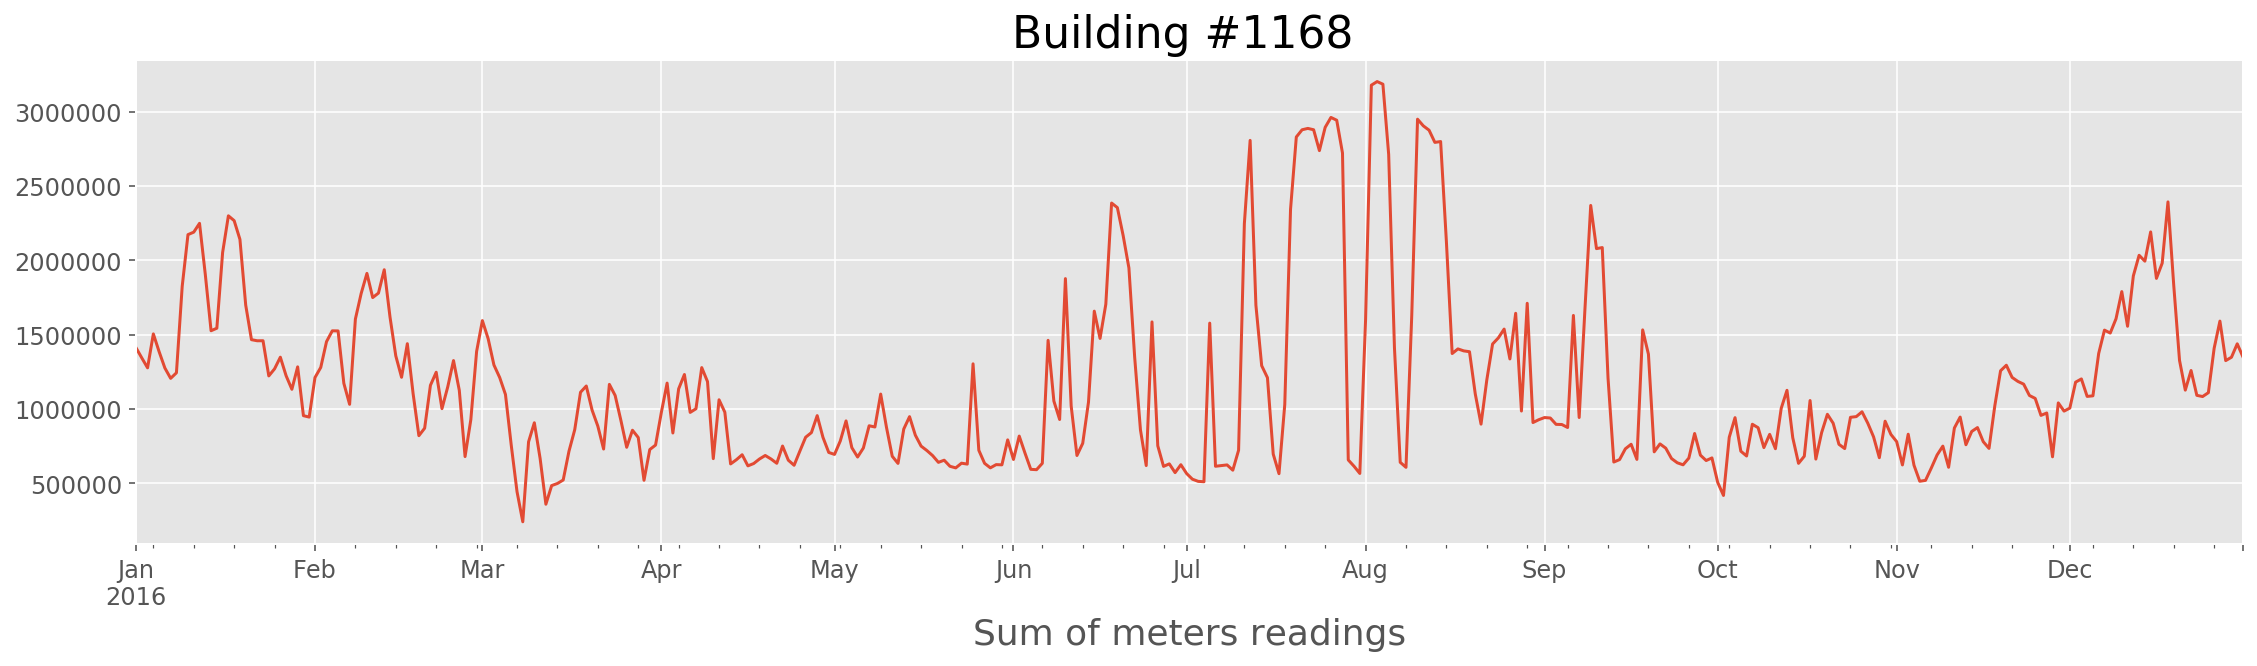

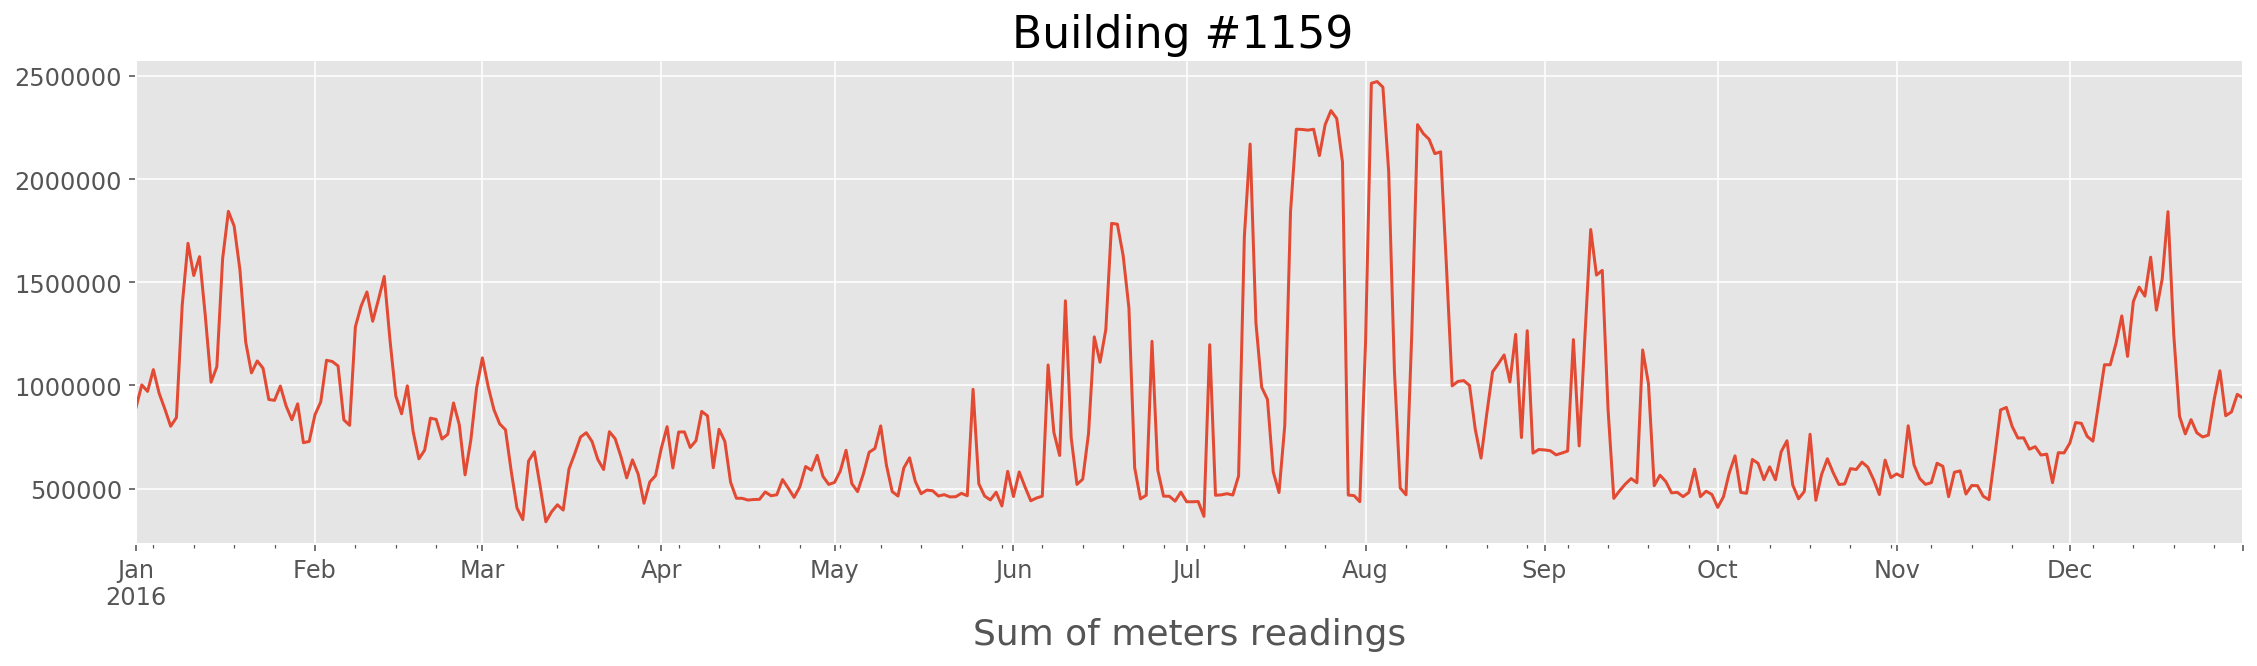

In [0]:
for bldg_id in [1099, 778, 1197, 1168, 1159]:
    plt.figure(figsize=(16,5))
    tmp_df = train_df[train_df.building_id == bldg_id].copy()
    tmp_df.set_index("timestamp", inplace=True)
    tmp_df.resample("D").meter_reading.sum().plot()
    plt.title(f"Building #{bldg_id} ")
    plt.xlabel("Sum of meters readings")
    plt.tight_layout()
    plt.show()

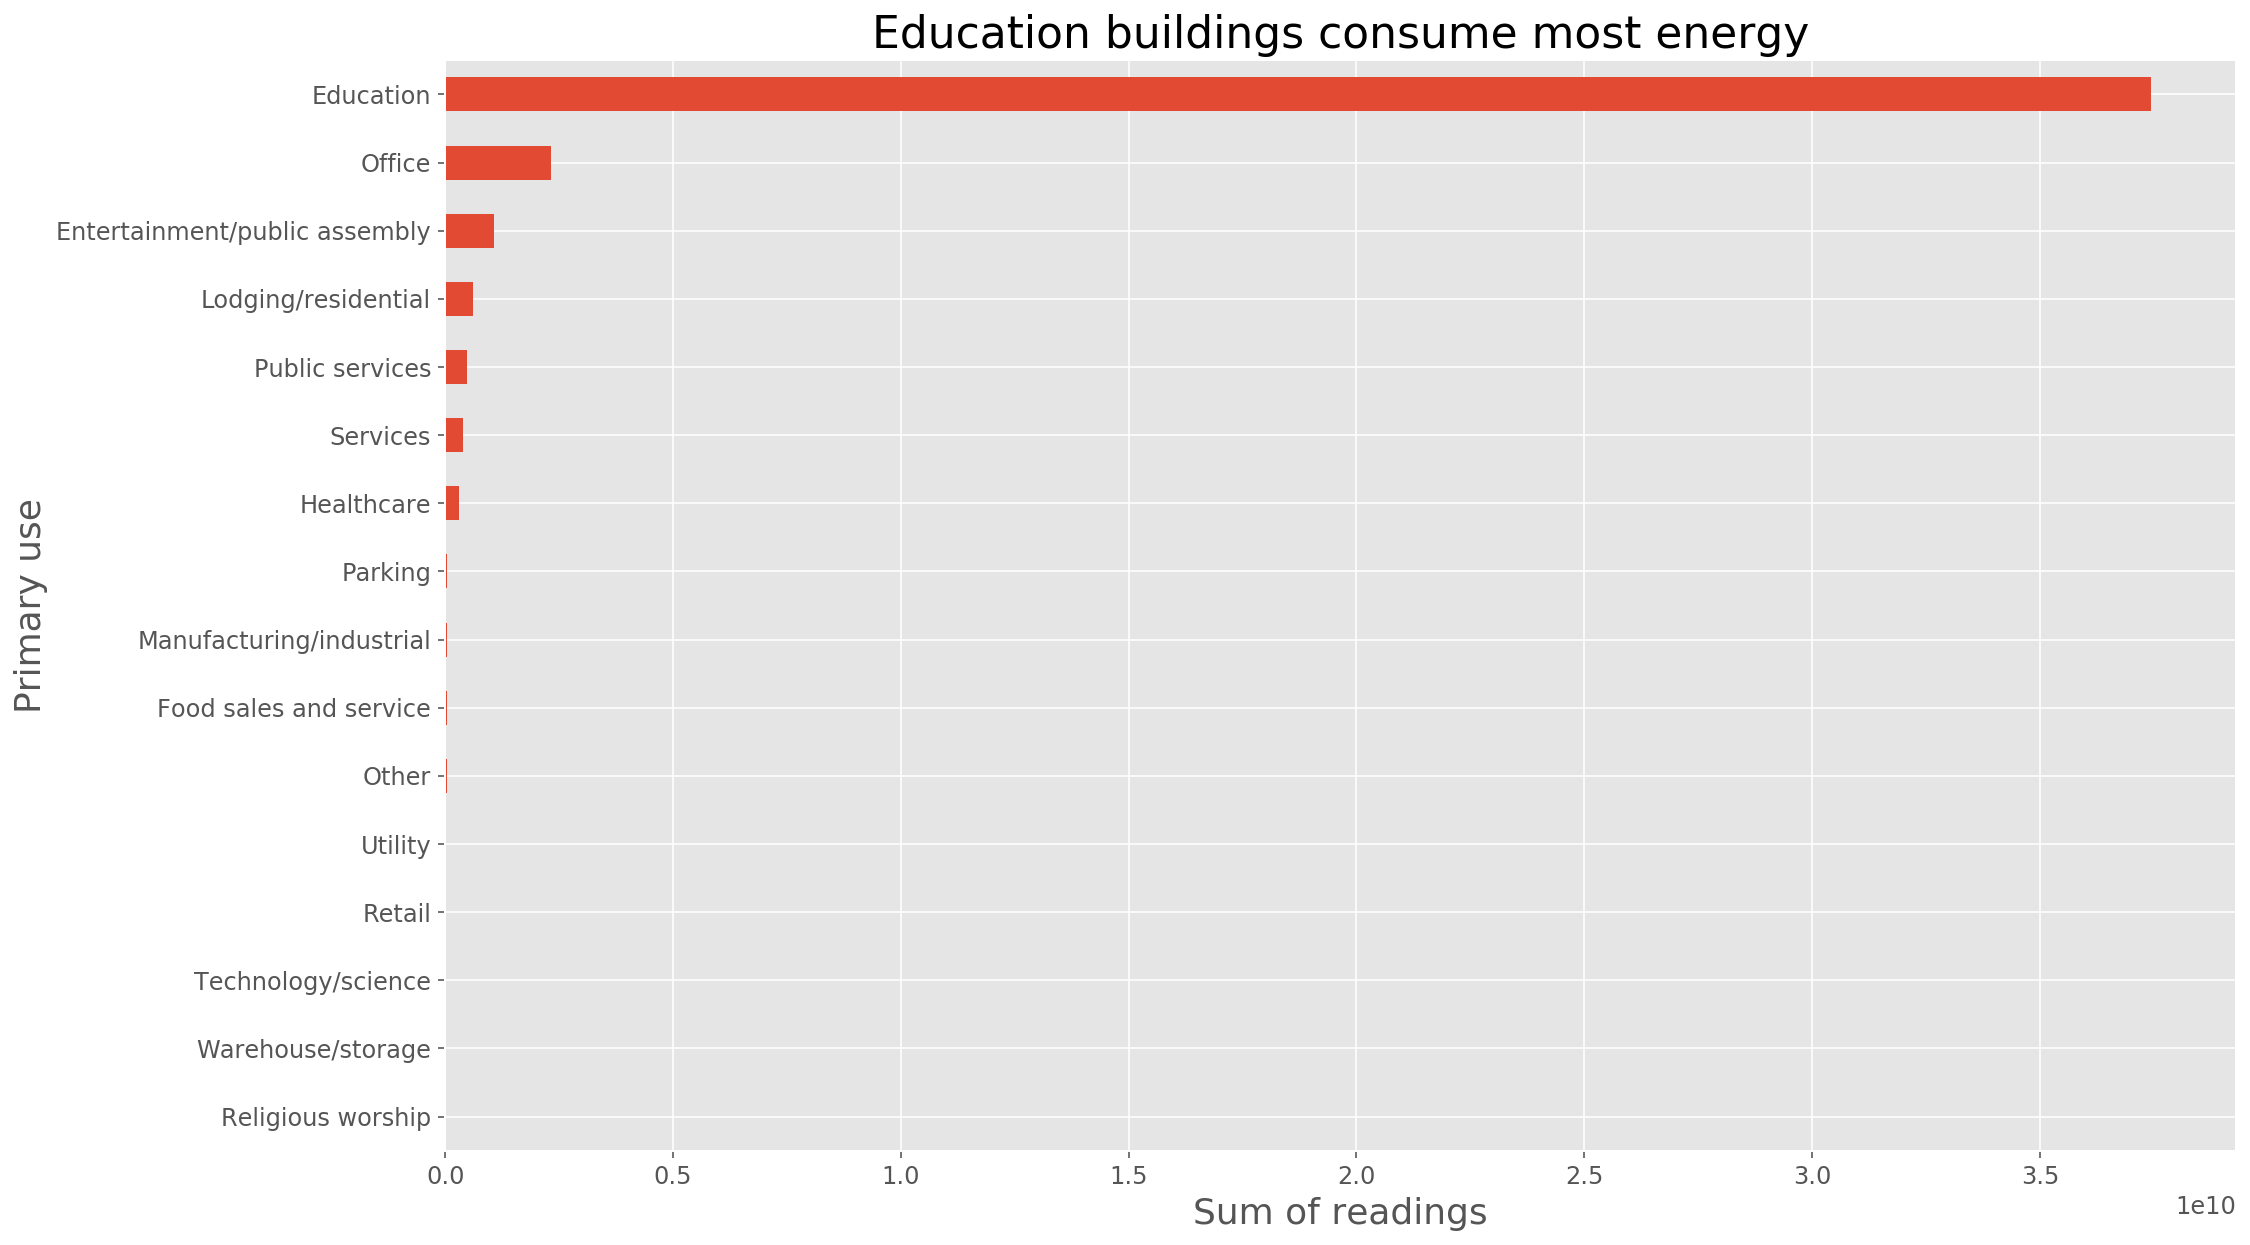

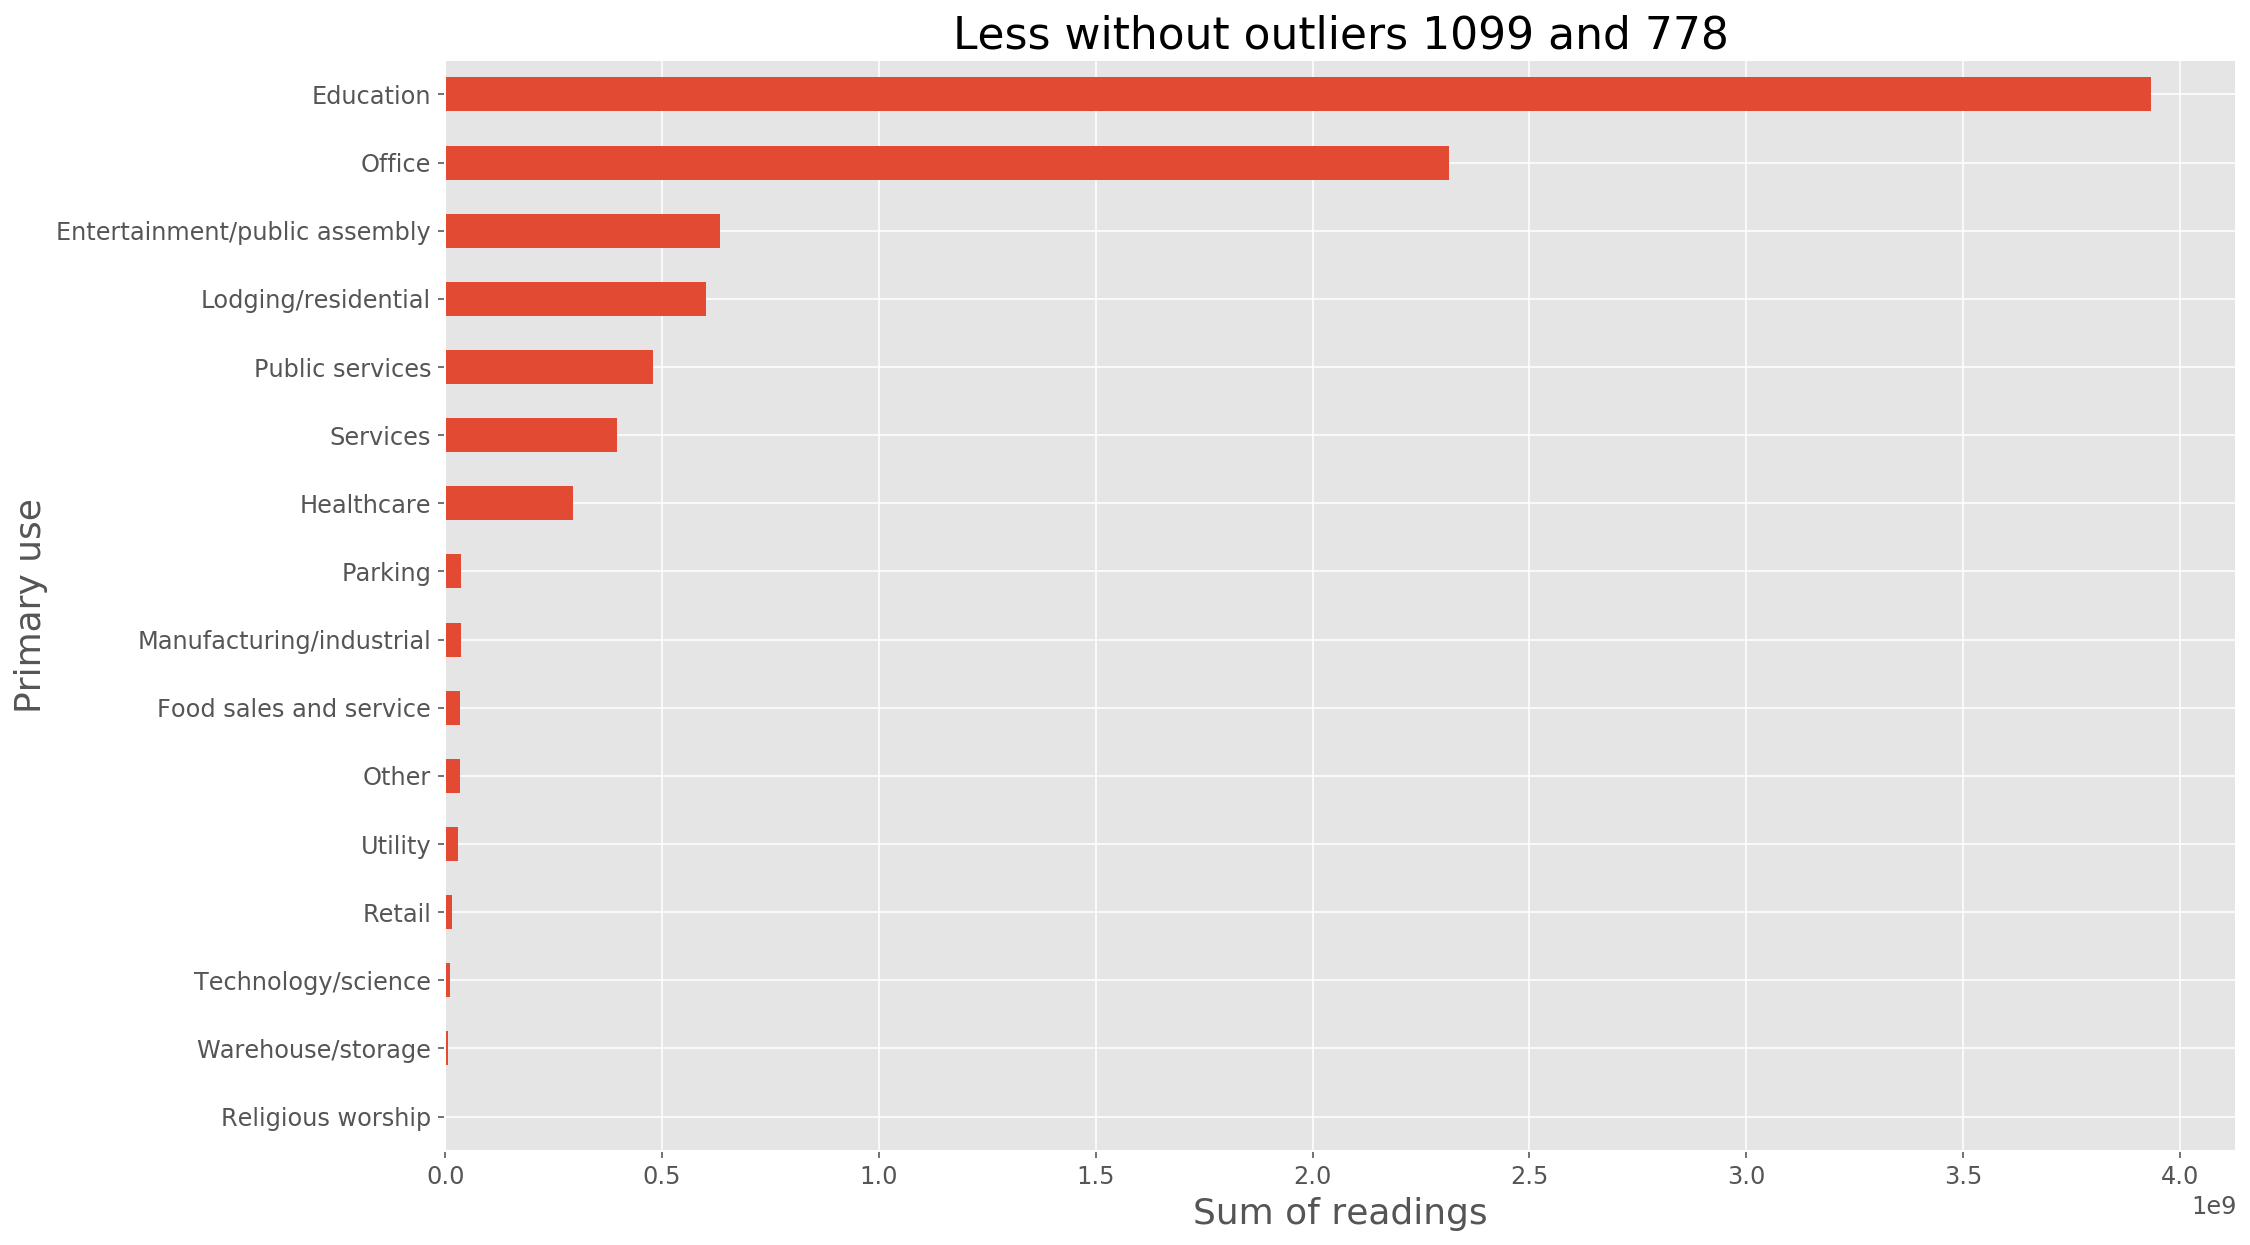

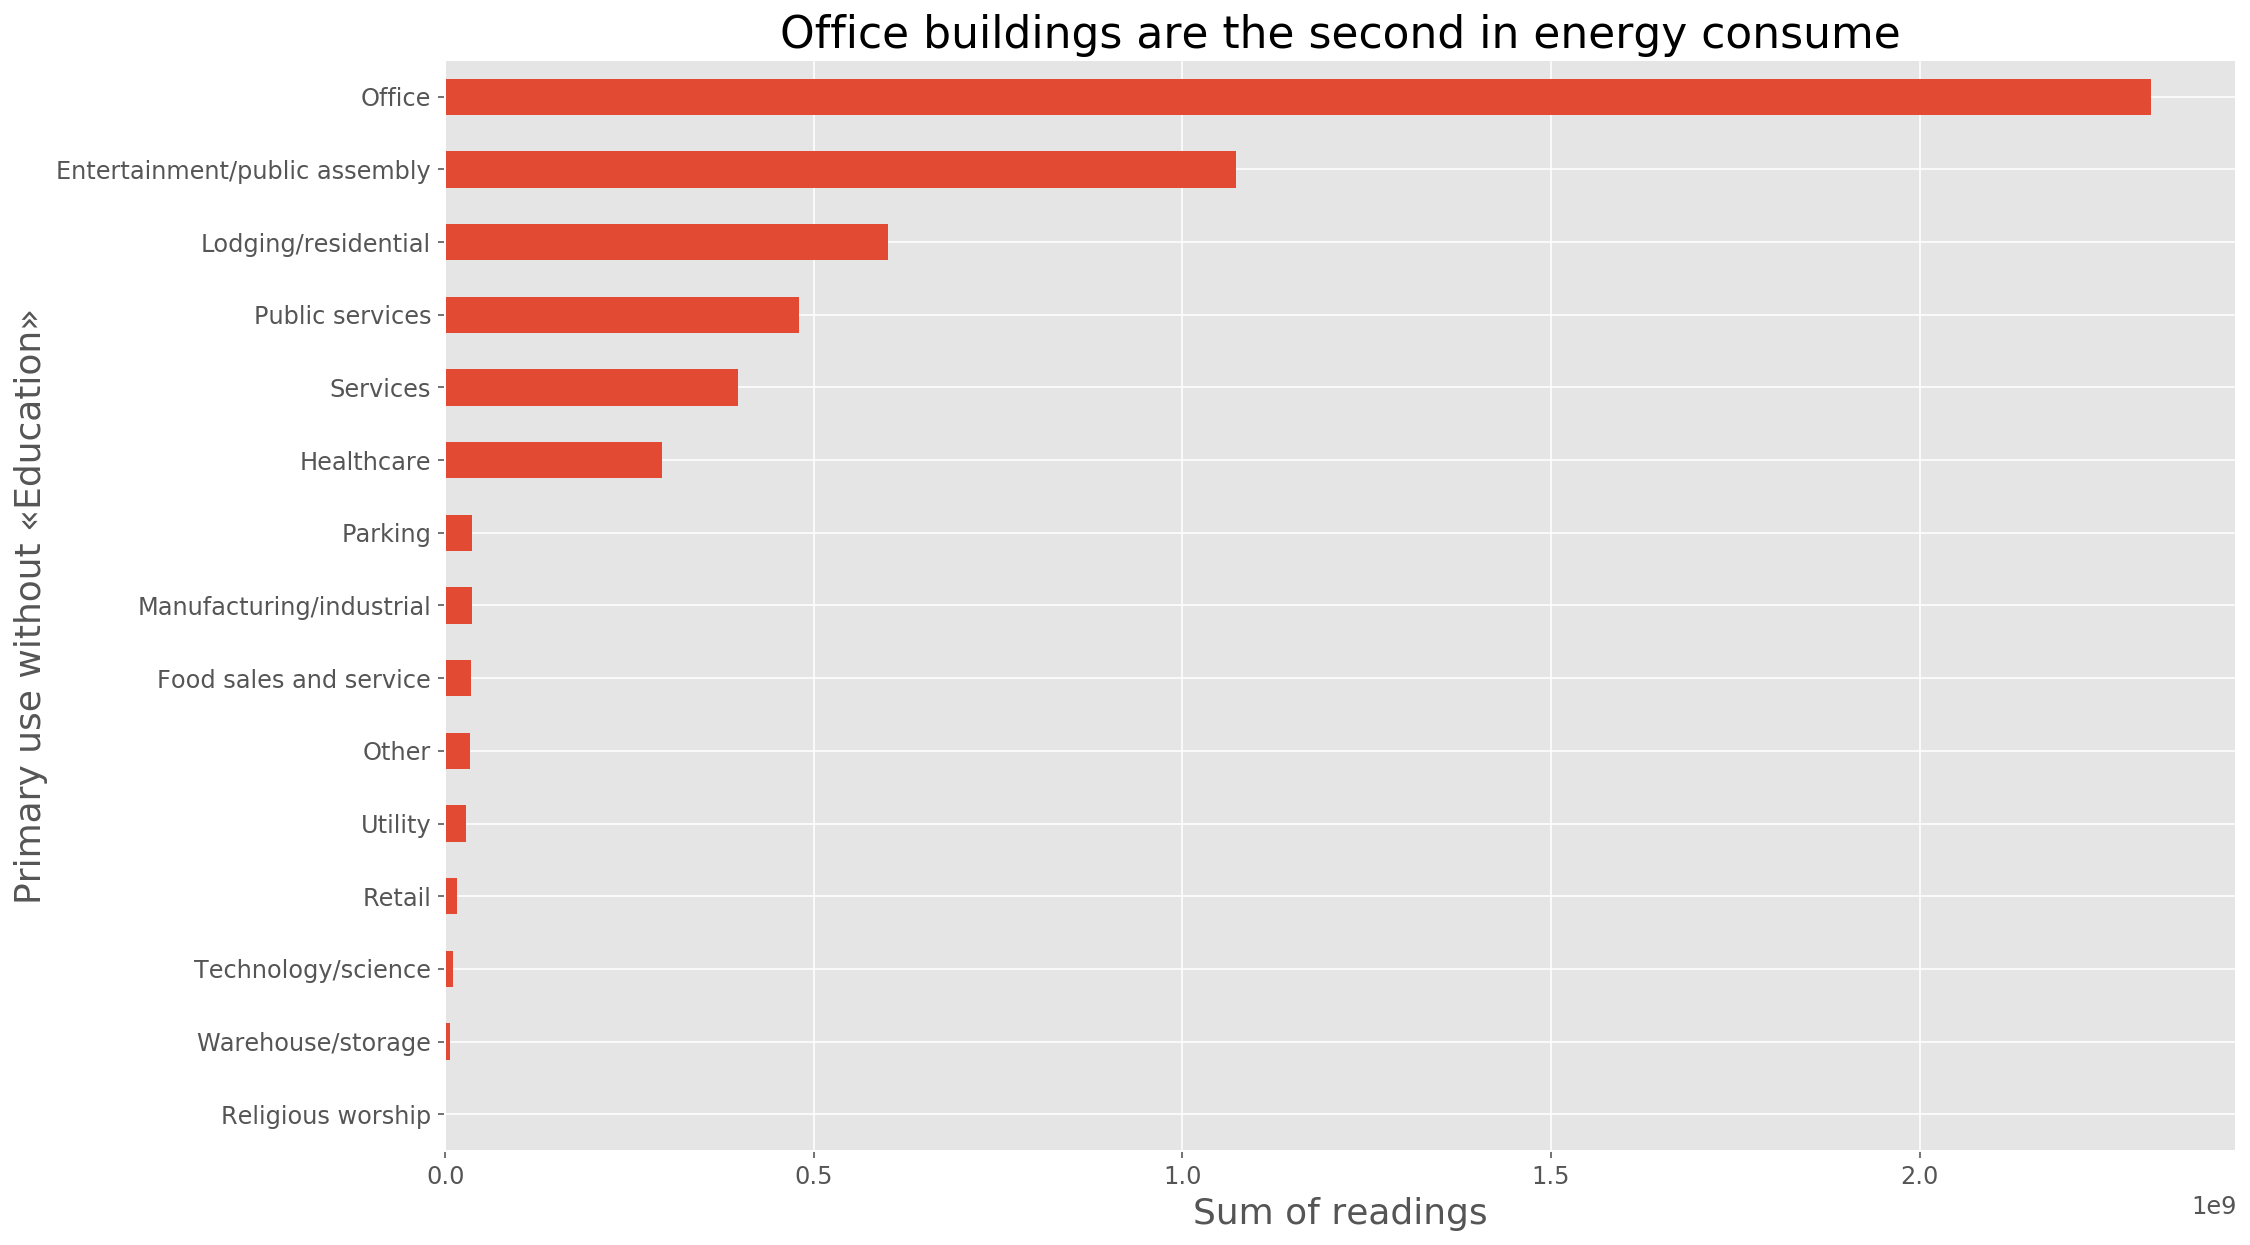

In [0]:
## Consumption per type of building
temp_df = train_df.groupby("primary_use").meter_reading.sum().sort_values()

outliers_index = train_df[train_df.building_id.isin([1099, 778])].index
temp_df_inliers = train_df.drop(outliers_index).groupby("primary_use").meter_reading.sum().sort_values()

plt.figure(figsize=(16,9))
temp_df.plot(kind="barh")
plt.title(f"Education buildings consume most energy")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
temp_df_inliers.plot(kind="barh")
plt.title(f"Less without outliers 1099 and 778")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,9))
temp_df[:-1].plot(kind="barh")
plt.title(f"Office buildings are the second in energy consume")
plt.xlabel("Sum of readings")
plt.ylabel(f"Primary use without «Education»")
plt.tight_layout()
plt.show()

In [0]:
## Square feet and consumption (Crushea) 
sq_binned = pd.cut(train_df.square_feet, bins=np.arange(0, 1_000_000, 100_000))
sq_binned = pd.DataFrame(sq_binned)
sq_binned.columns = ["sq_binned"]
tmp_df = pd.concat([train_df, sq_binned], axis=1).groupby("sq_binned").meter_reading.mean().sort_index()

plt.figure(figsize=(16,7))
tmp_df.plot(kind="barh")
plt.title(f"Buildings between 300-400k square feet consume most energy")
plt.xlabel("Mean of consumption")
plt.ylabel(f"Binned square feet of building")
plt.tight_layout()
plt.show()

In [0]:
plt.figure(figsize=(16,5))
train_df.groupby("building_id").meter.nunique().value_counts().sort_index().plot(kind="bar")
plt.title(f"Most buildings have 1 or 3 type of meter reading")
plt.ylabel("Count of buildings")
plt.xlabel(f"Types of meters")
plt.tight_layout()
plt.show()

In [0]:
## Number of buildings and the readings they provide
display(tmp_df.building_id.value_counts())

(0, 10000]        877
(20000, 30000]    326
(10000, 20000]    234
(30000, 40000]     12
Name: building_id, dtype: int64

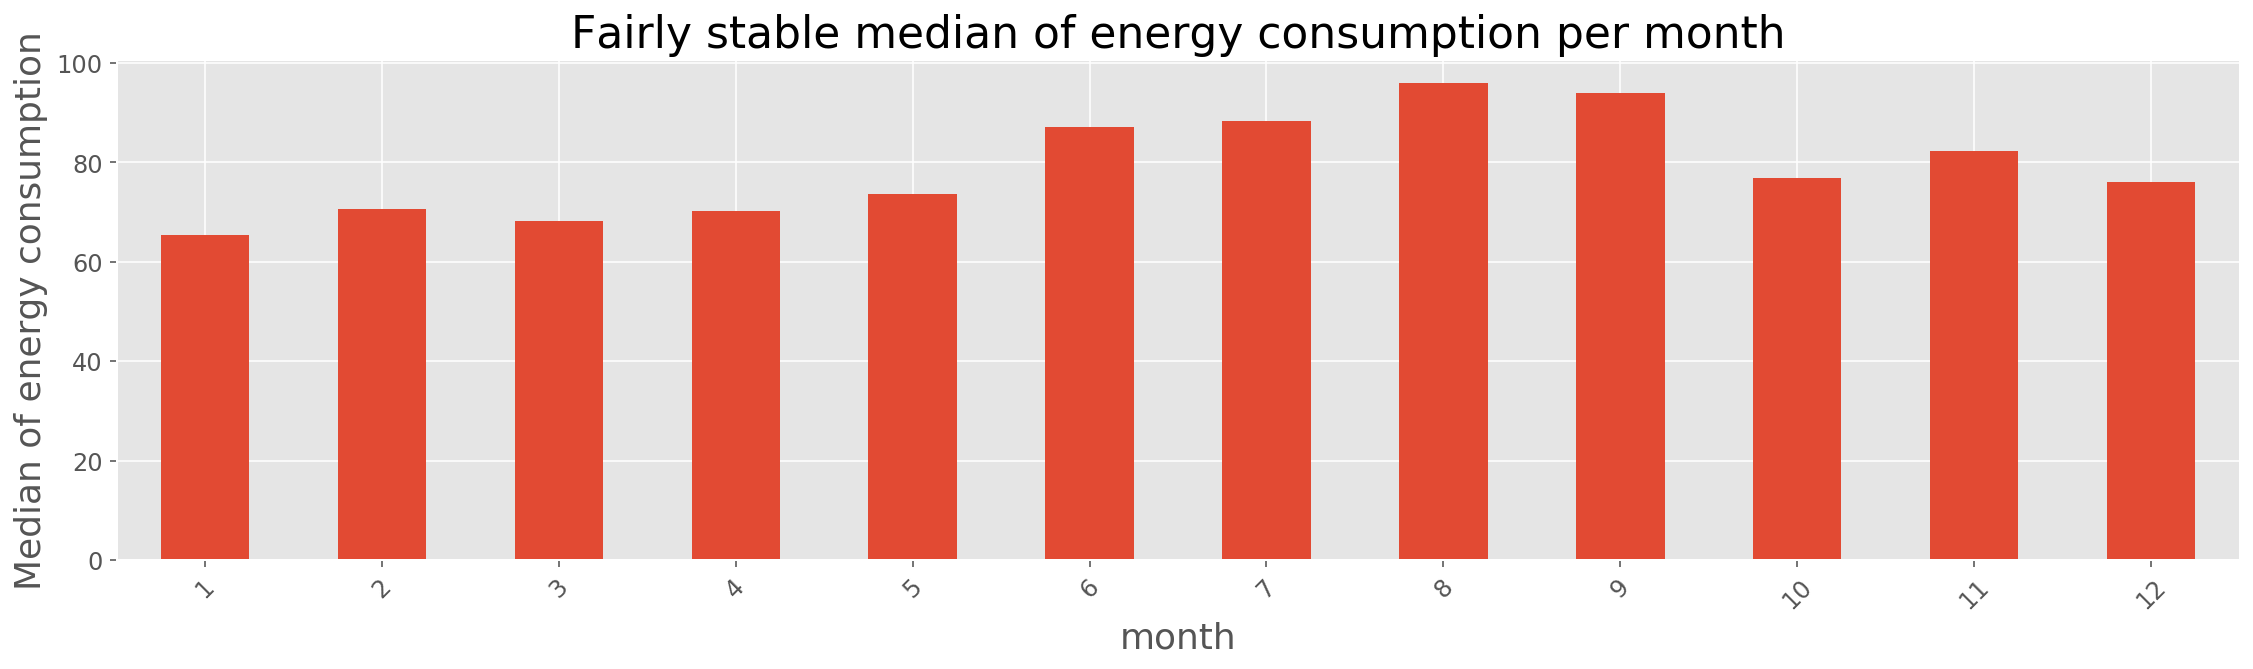

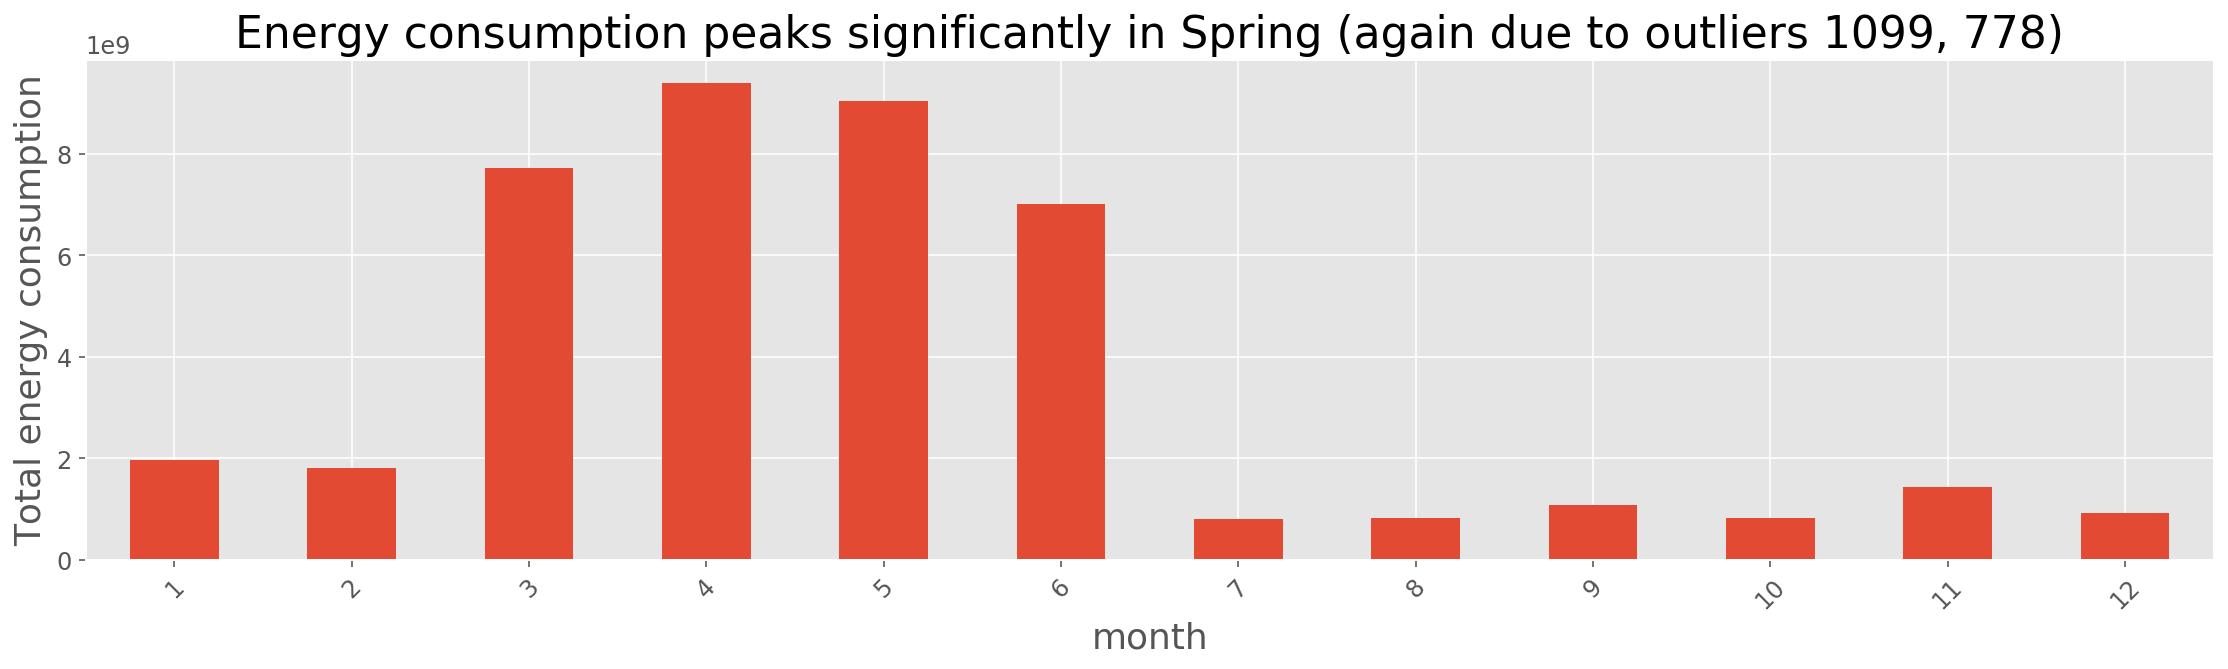

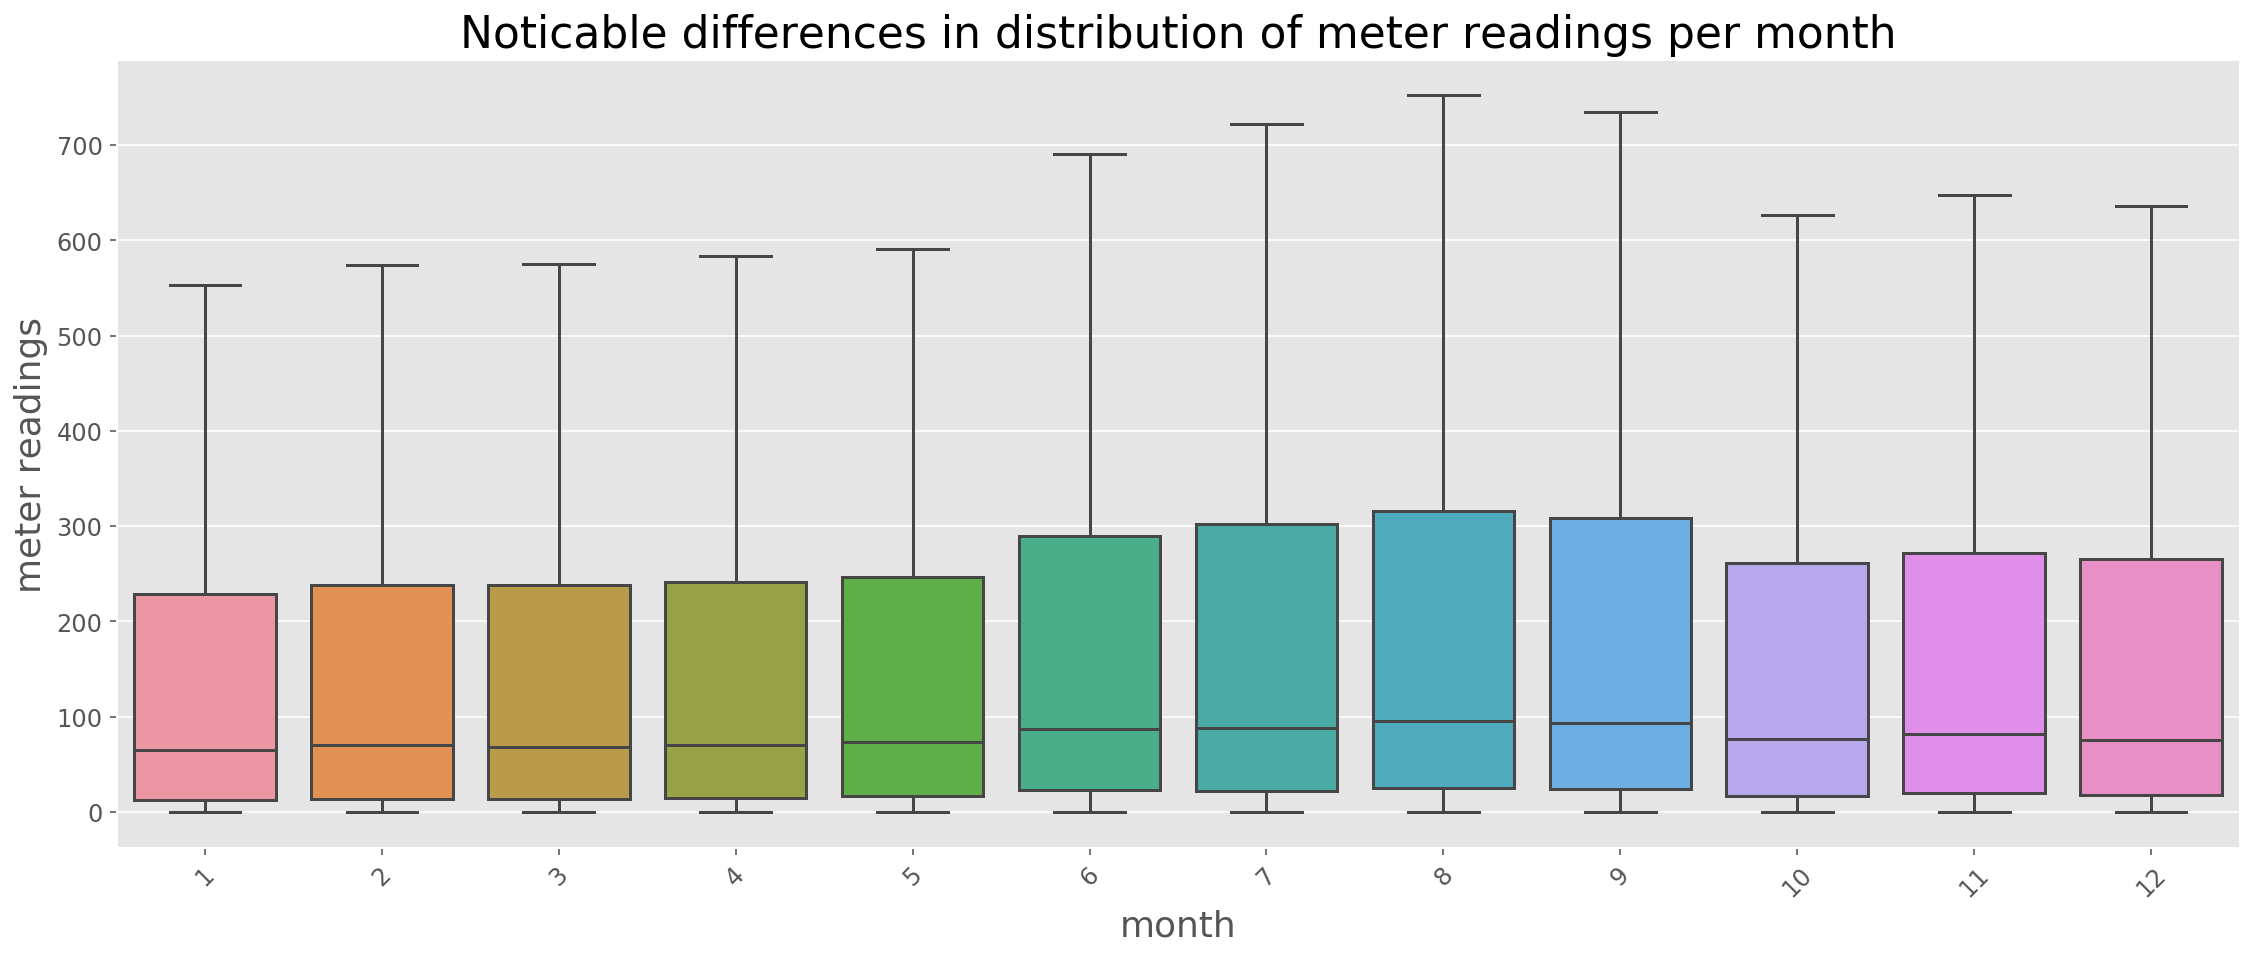

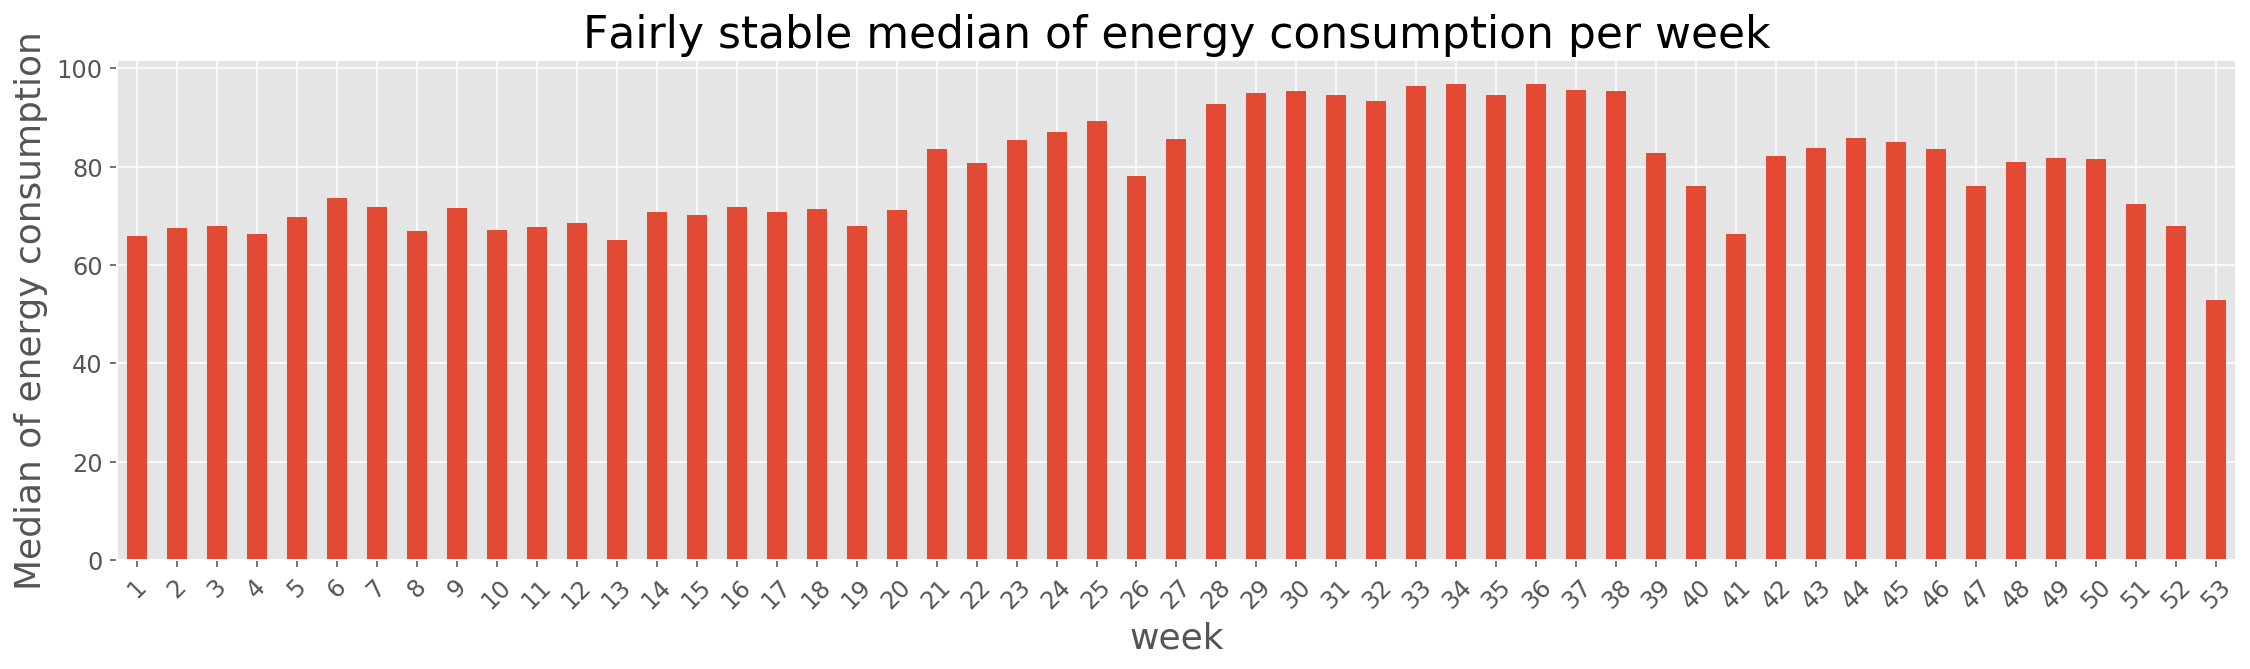

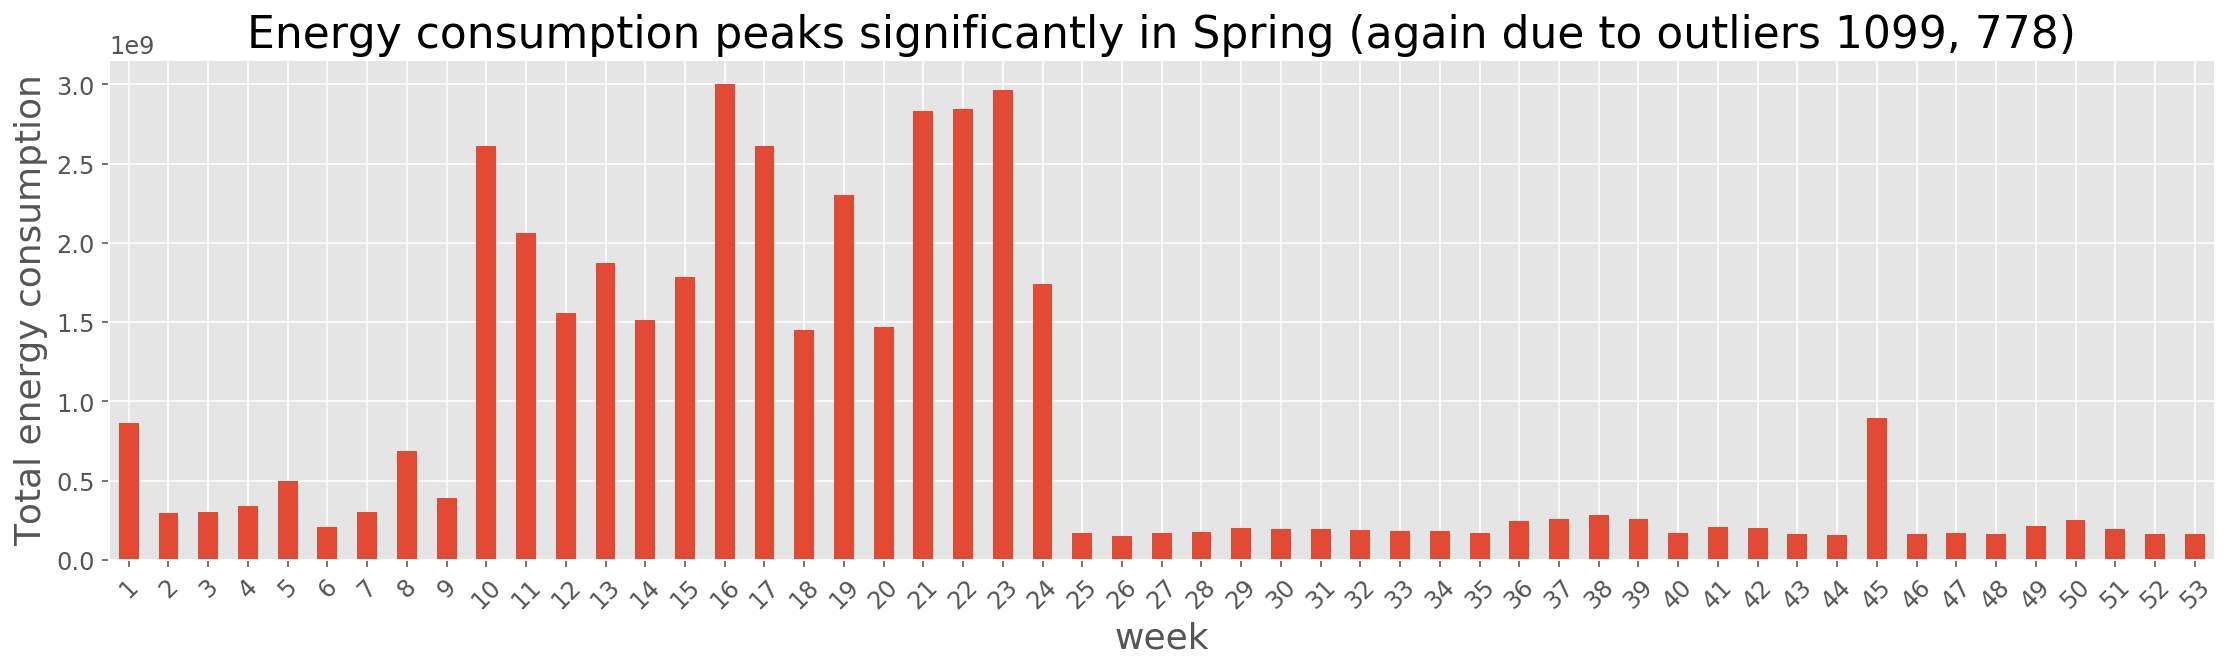

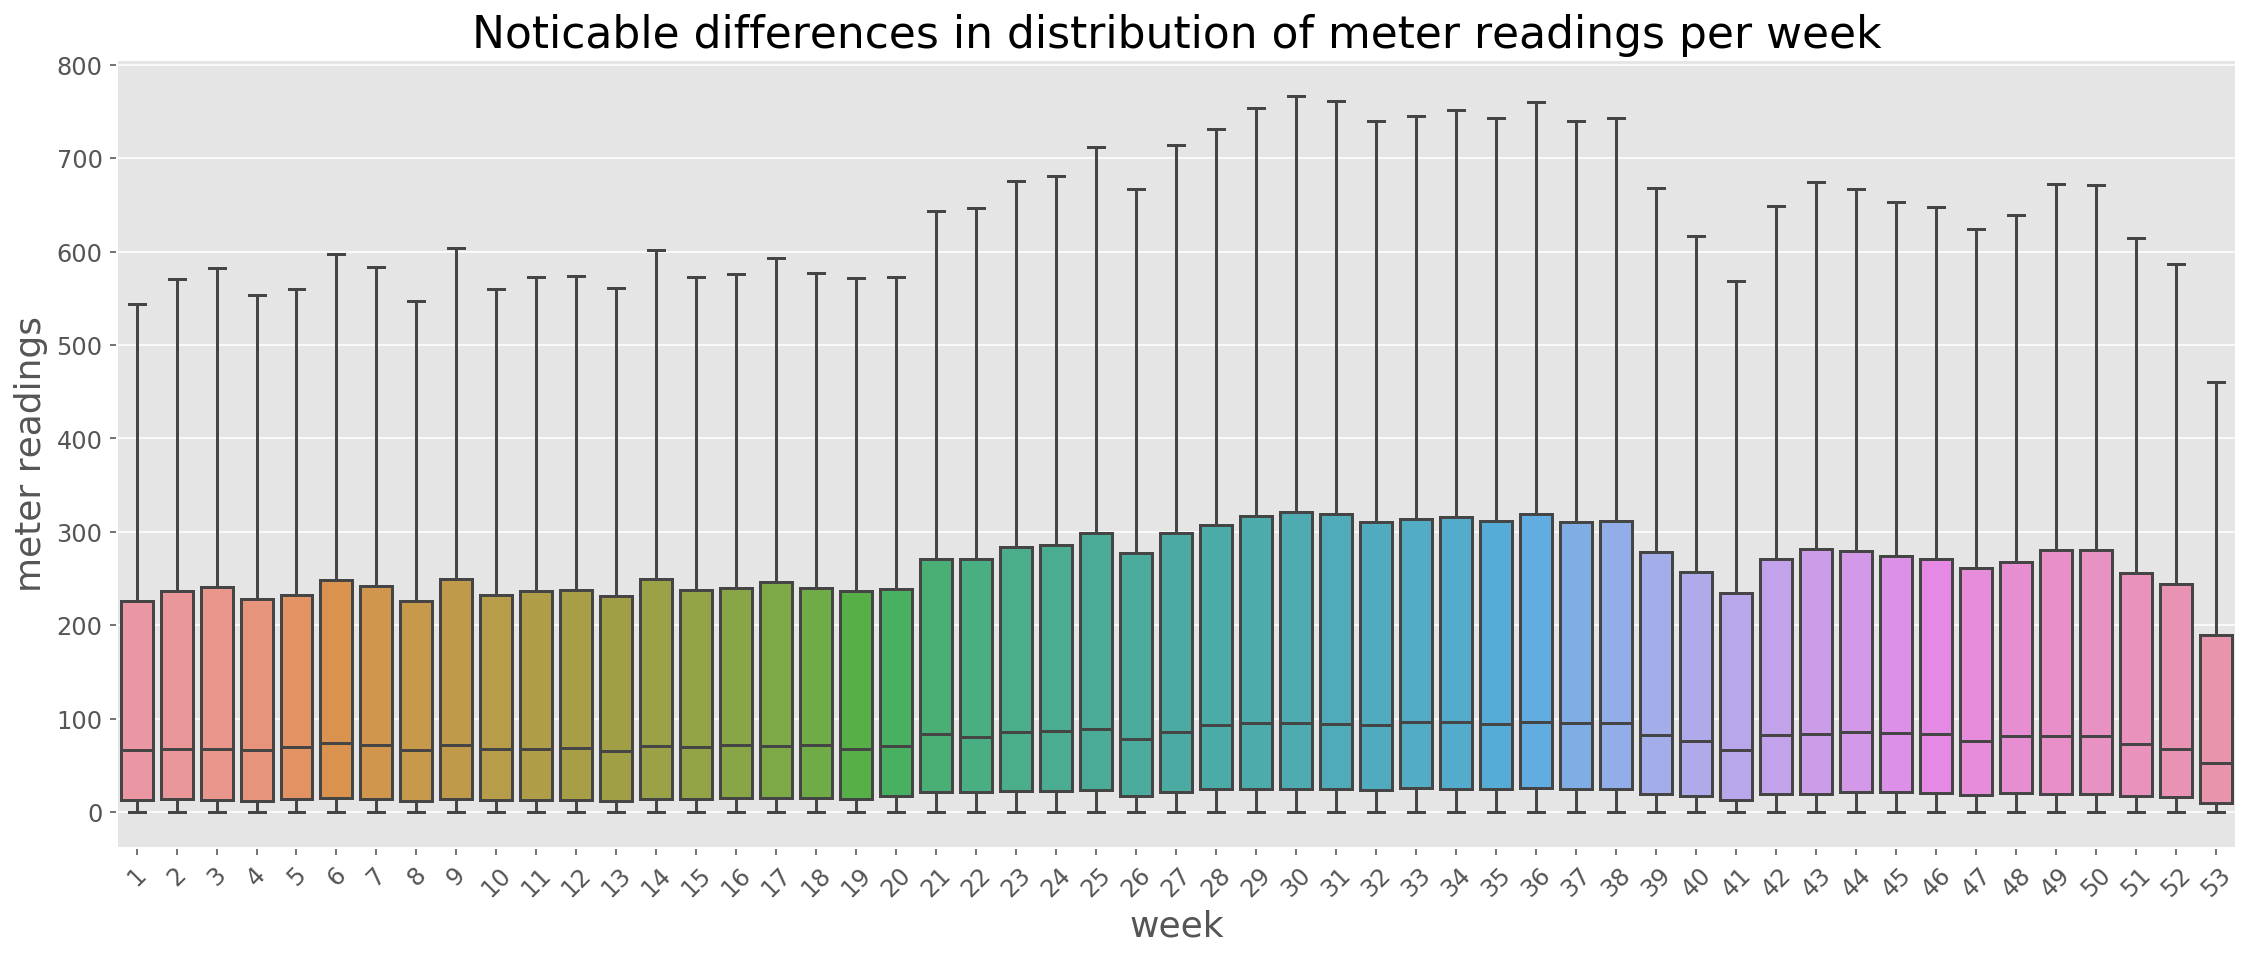

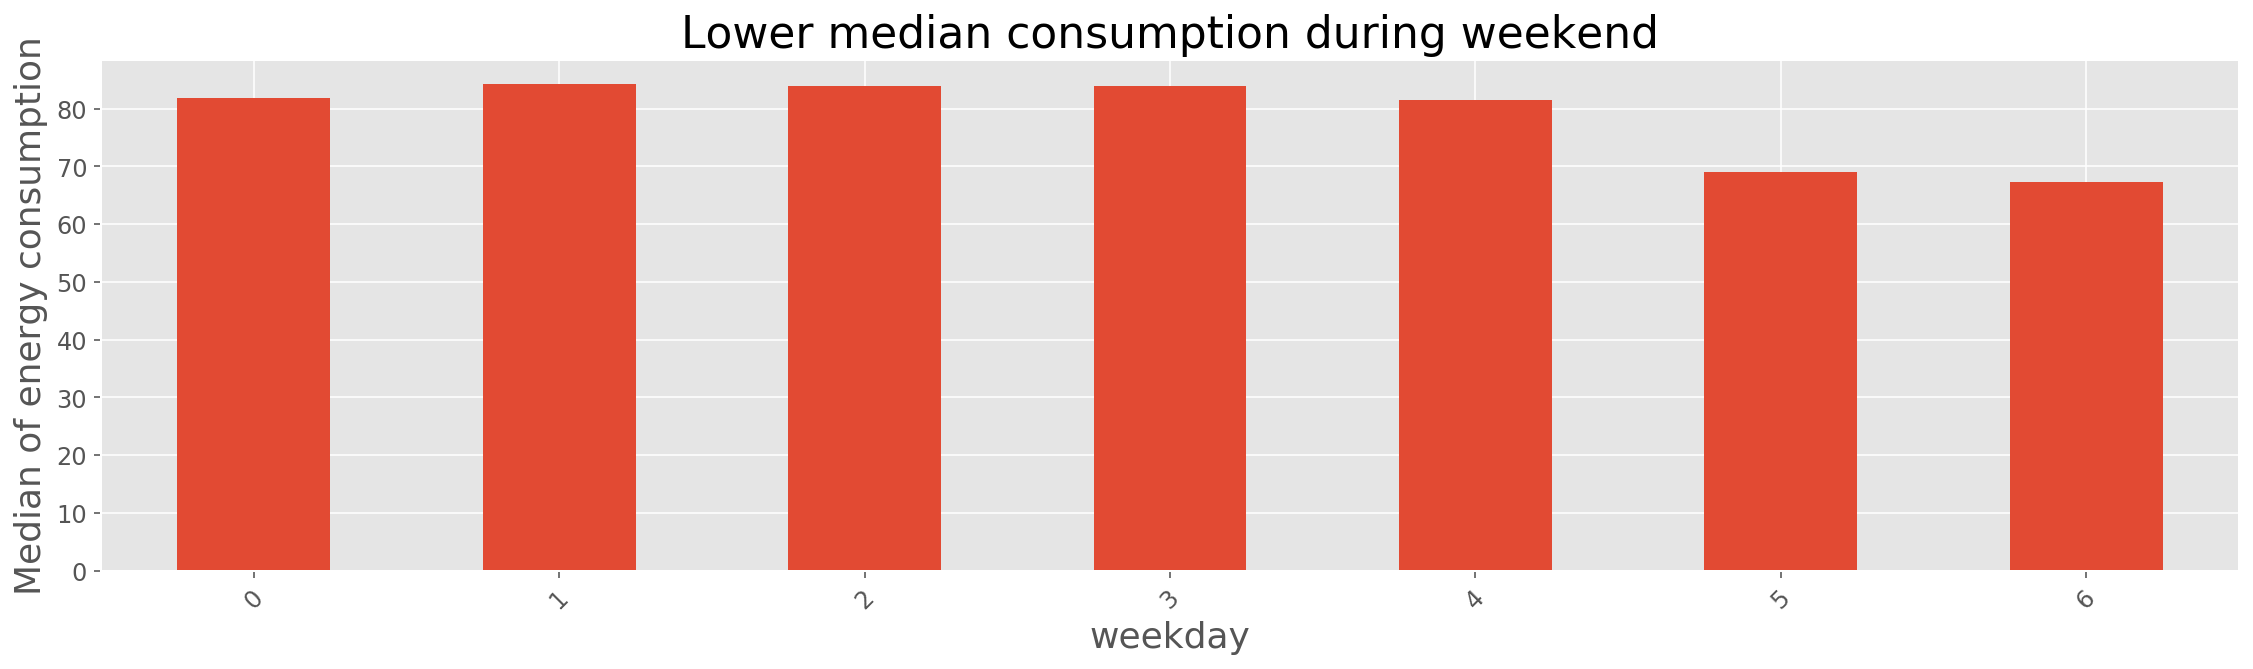

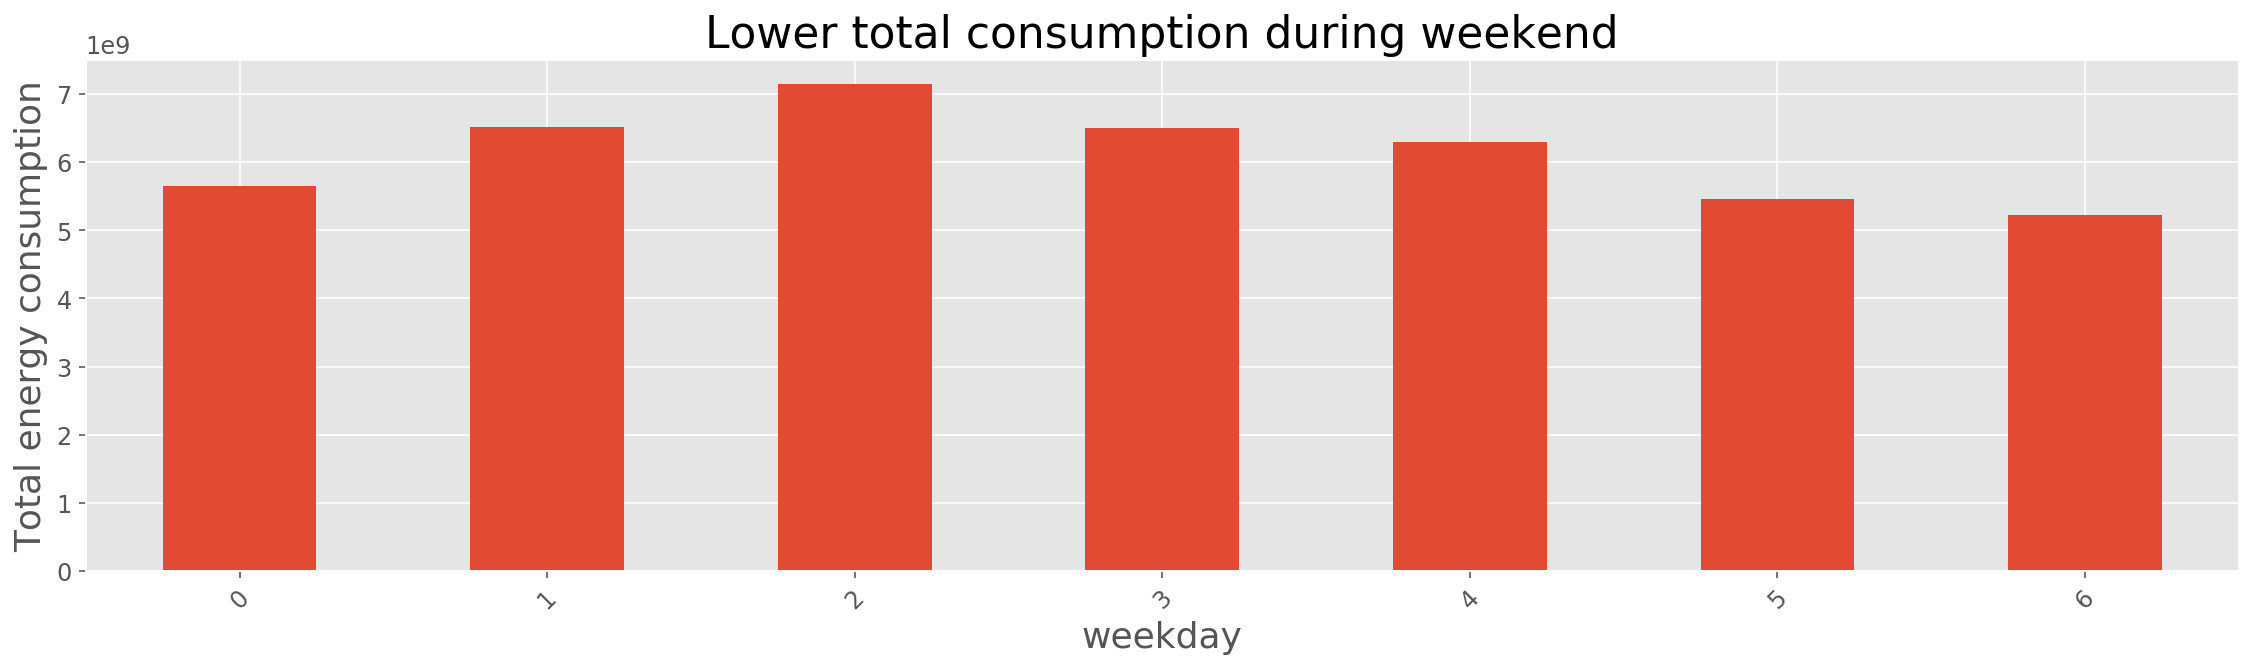

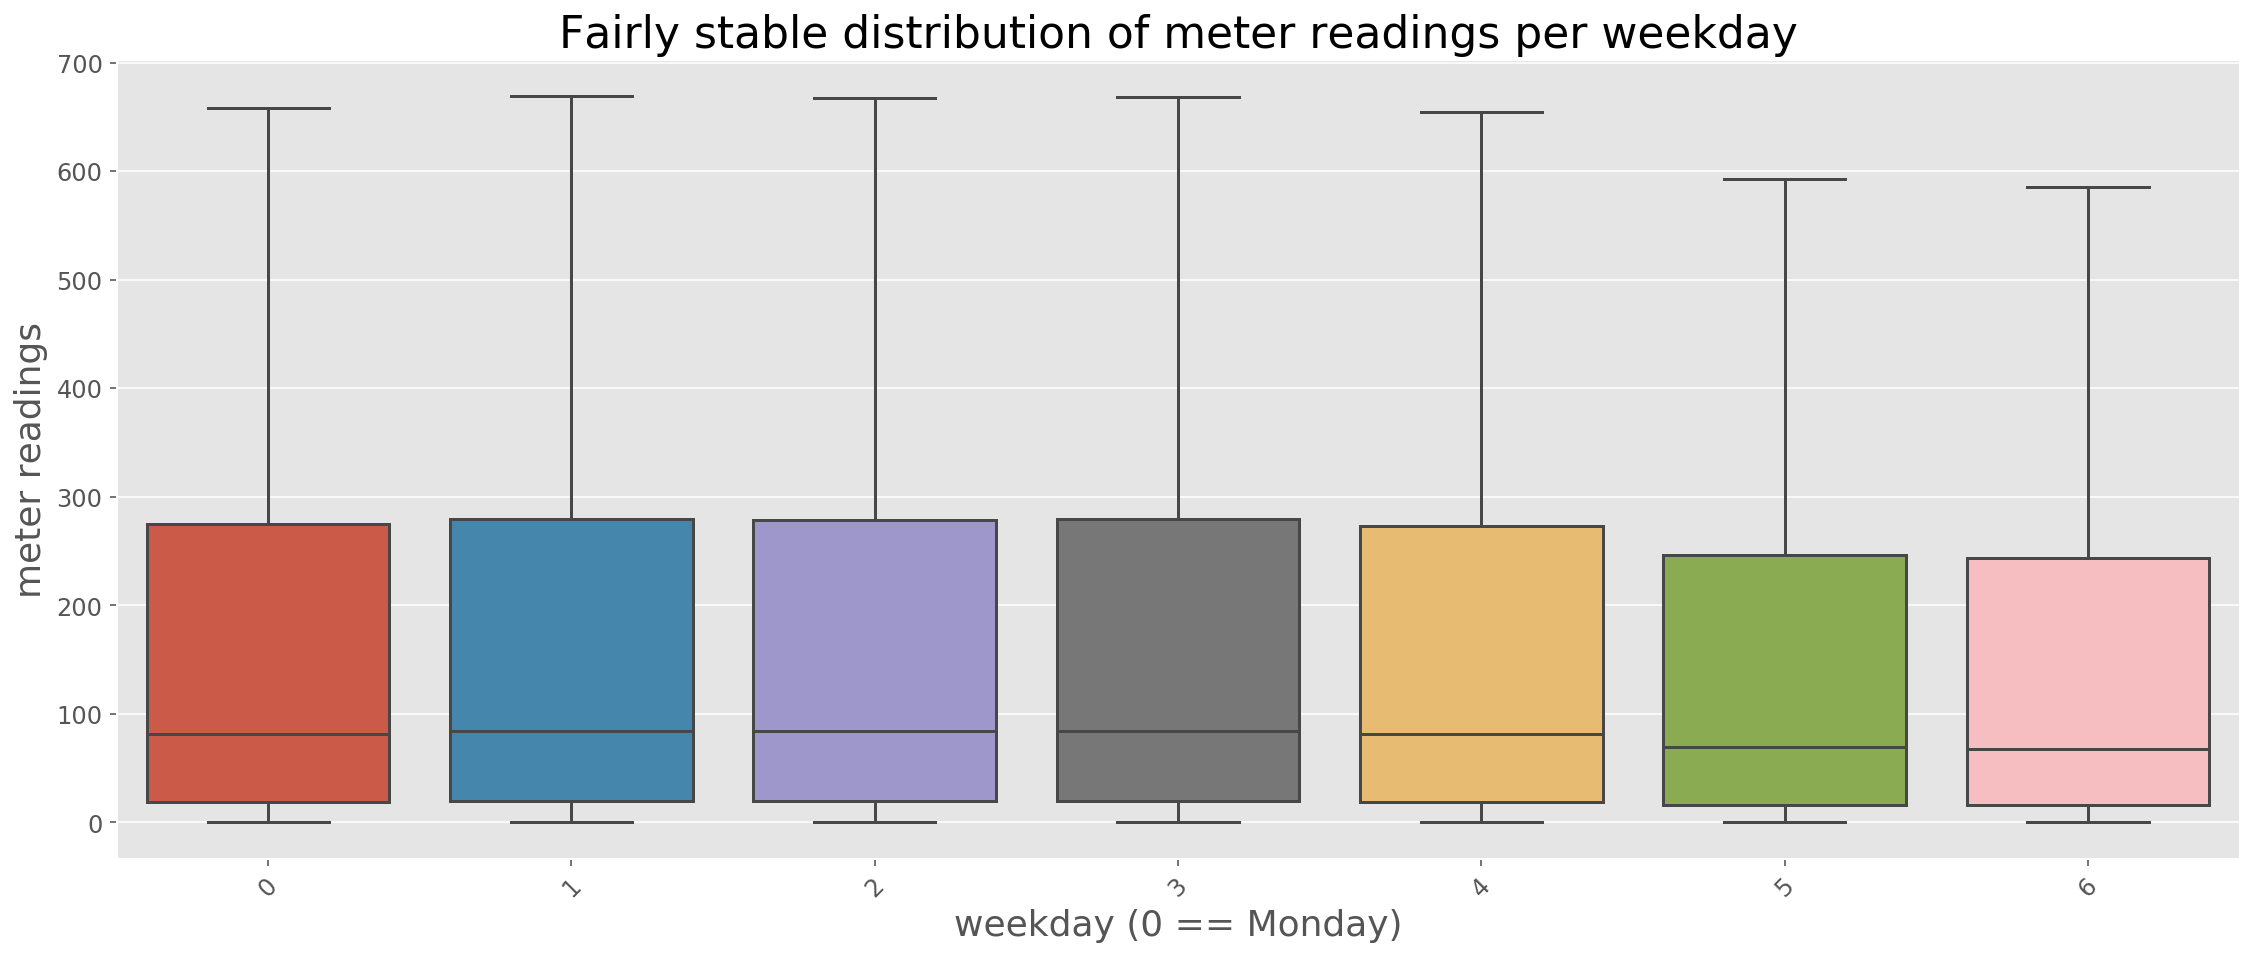

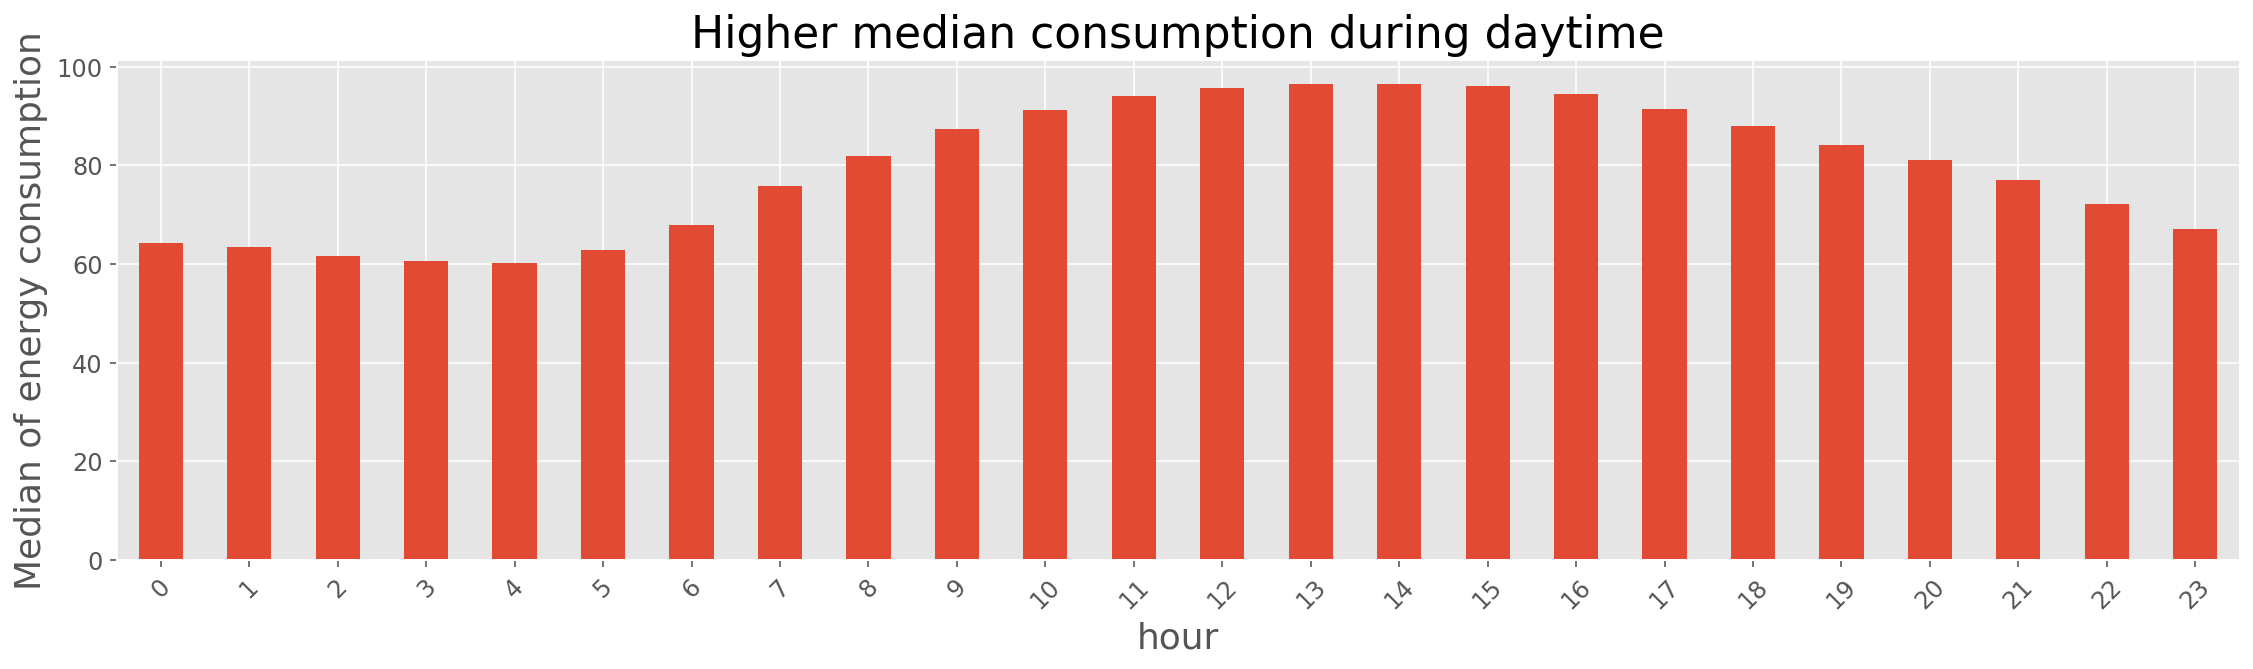

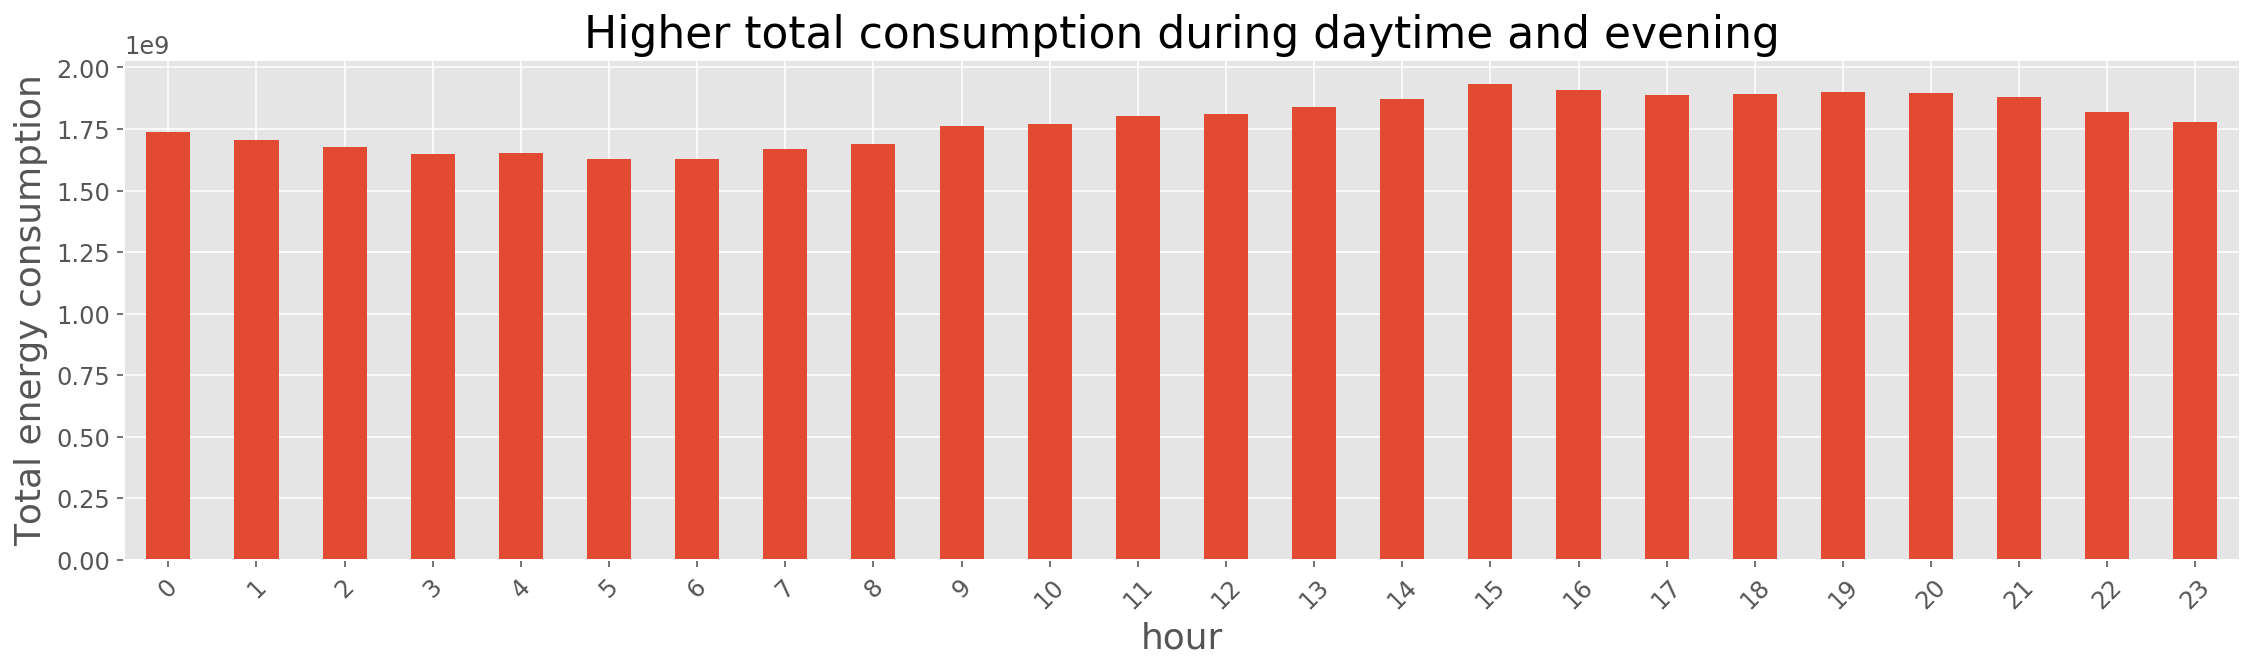

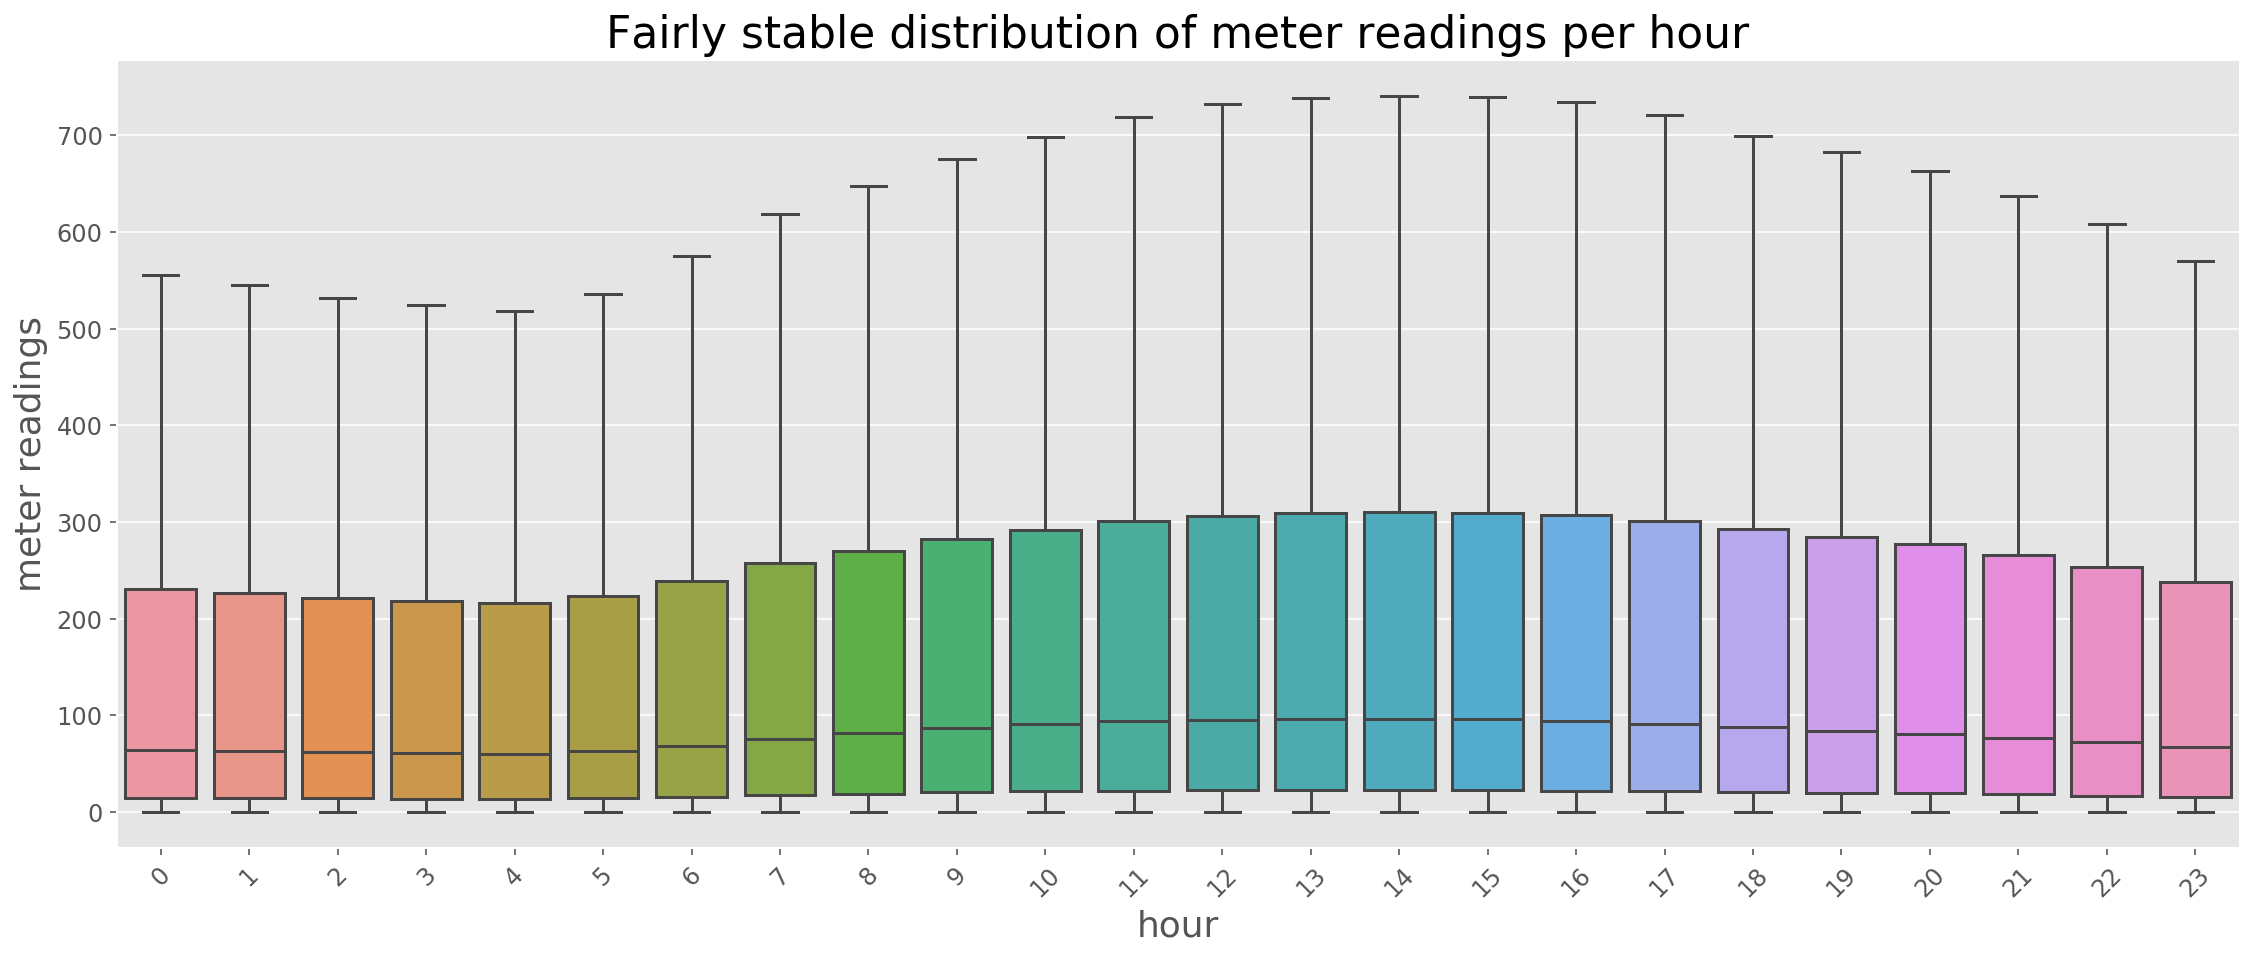

In [0]:
## Sum of energy consumption per time
for timeframe_name, timeframe in timeframes.items():
    plt.figure(figsize=(16,5))
    train_df.groupby(timeframe).meter_reading.median().plot(kind="bar")
    plt.title(f"Fairly stable median of energy consumption per {timeframe_name}")
    plt.ylabel("Median of energy consumption")
    plt.xlabel(f"{timeframe_name}")
    plt.xticks(rotation=45)
    
    if timeframe_name == "weekday":
        plt.title("Lower median consumption during weekend")
    if timeframe_name == "hour":
        plt.title("Higher median consumption during daytime")
        
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(16,5))
    train_df.groupby(timeframe).meter_reading.sum().plot(kind="bar")
    plt.title(f"Energy consumption peaks significantly in Spring (again due to outliers 1099, 778)")
    plt.ylabel("Total energy consumption")
    plt.xlabel(f"{timeframe_name}")
    plt.xticks(rotation=45)
    
    if timeframe_name == "weekday":
        plt.title("Lower total consumption during weekend")
    if timeframe_name == "hour":
        plt.title("Higher total consumption during daytime and evening")
        
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(16,7))
    sns.boxplot(x=timeframe, y="meter_reading", data=train_df, showfliers=False)
    plt.title(f"Noticable differences in distribution of meter readings per {timeframe_name}")
    plt.ylabel("meter readings")
    plt.xlabel(f"{timeframe_name}")
    plt.xticks(rotation=45)
    
    if timeframe_name == "weekday":
            plt.title(f"Fairly stable distribution of meter readings per {timeframe_name}")
            plt.xlabel(f"{timeframe_name} (0 == Monday)")
    if timeframe_name == "hour":
            plt.title(f"Fairly stable distribution of meter readings per {timeframe_name}")

    plt.tight_layout()
    plt.show()

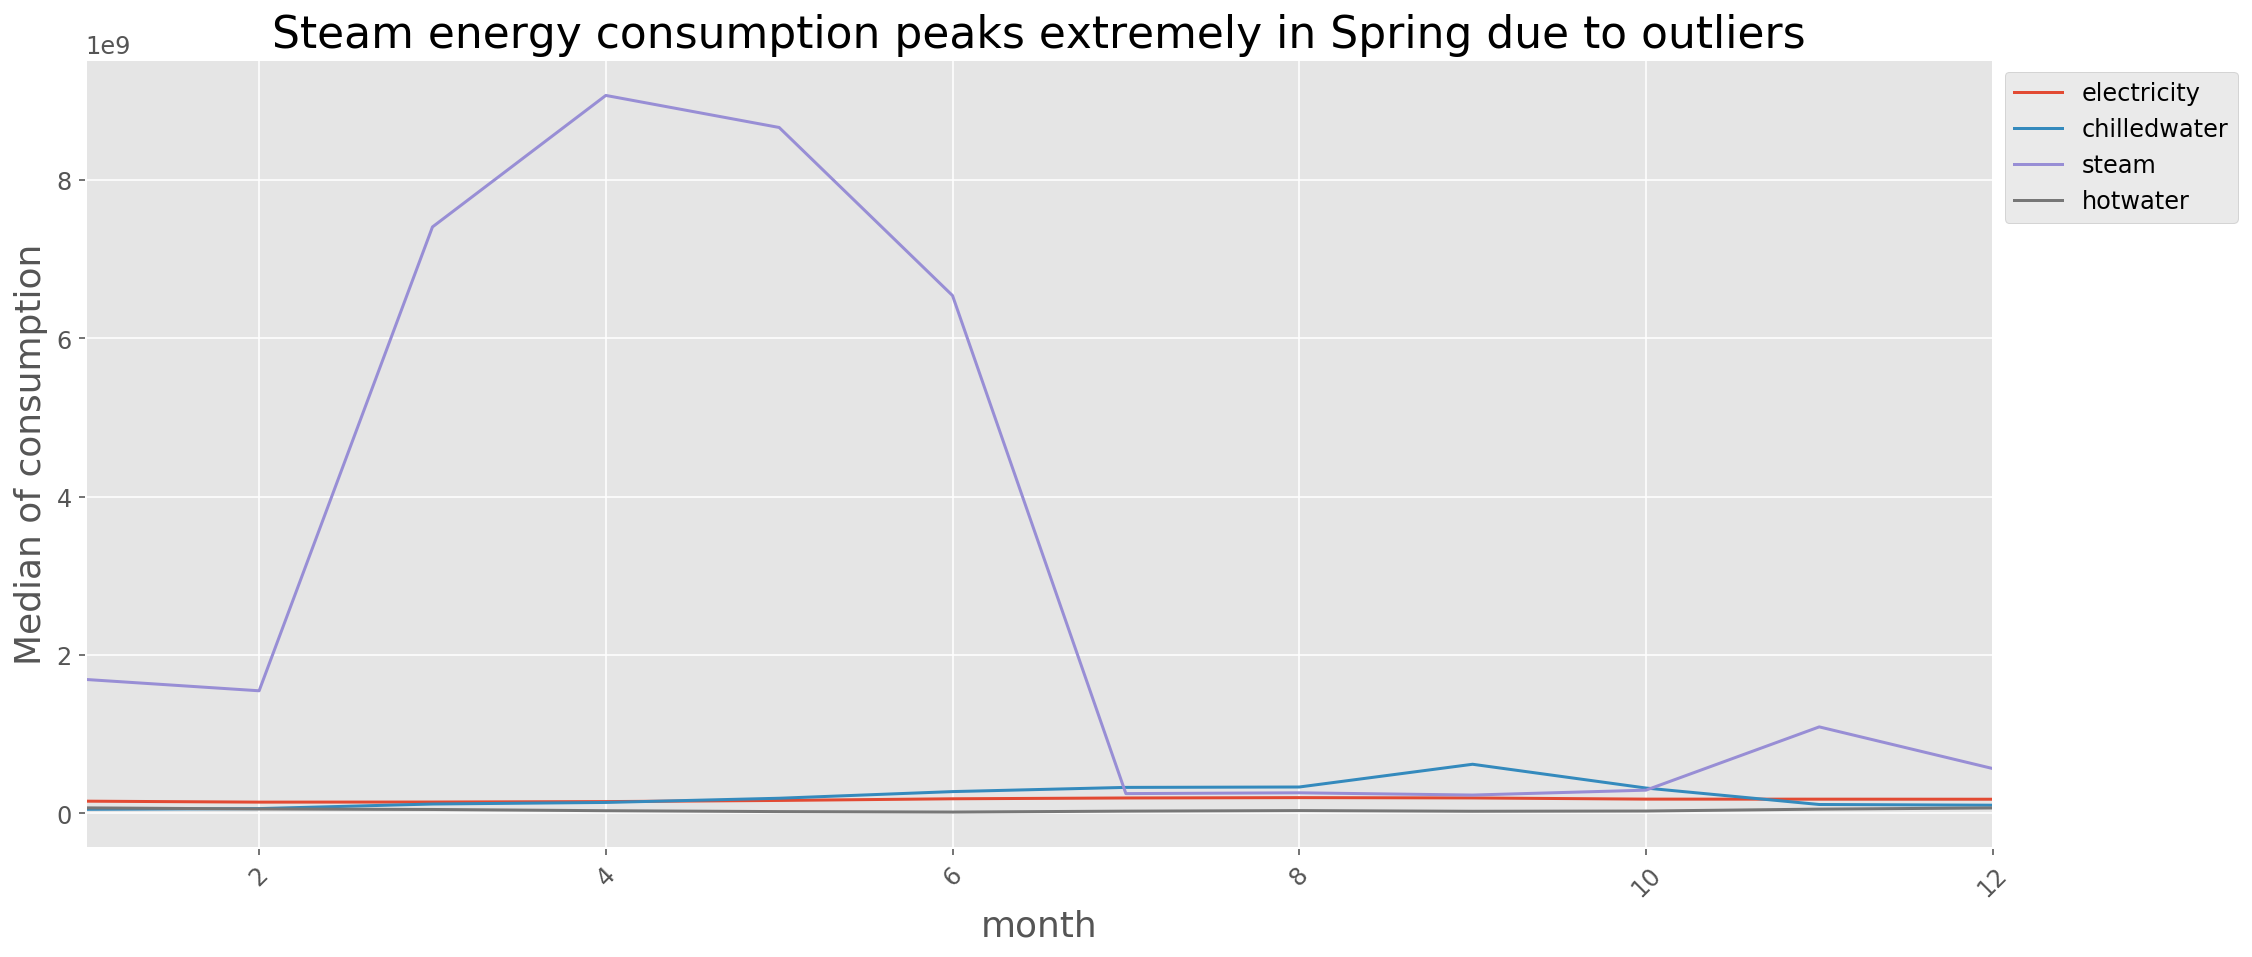

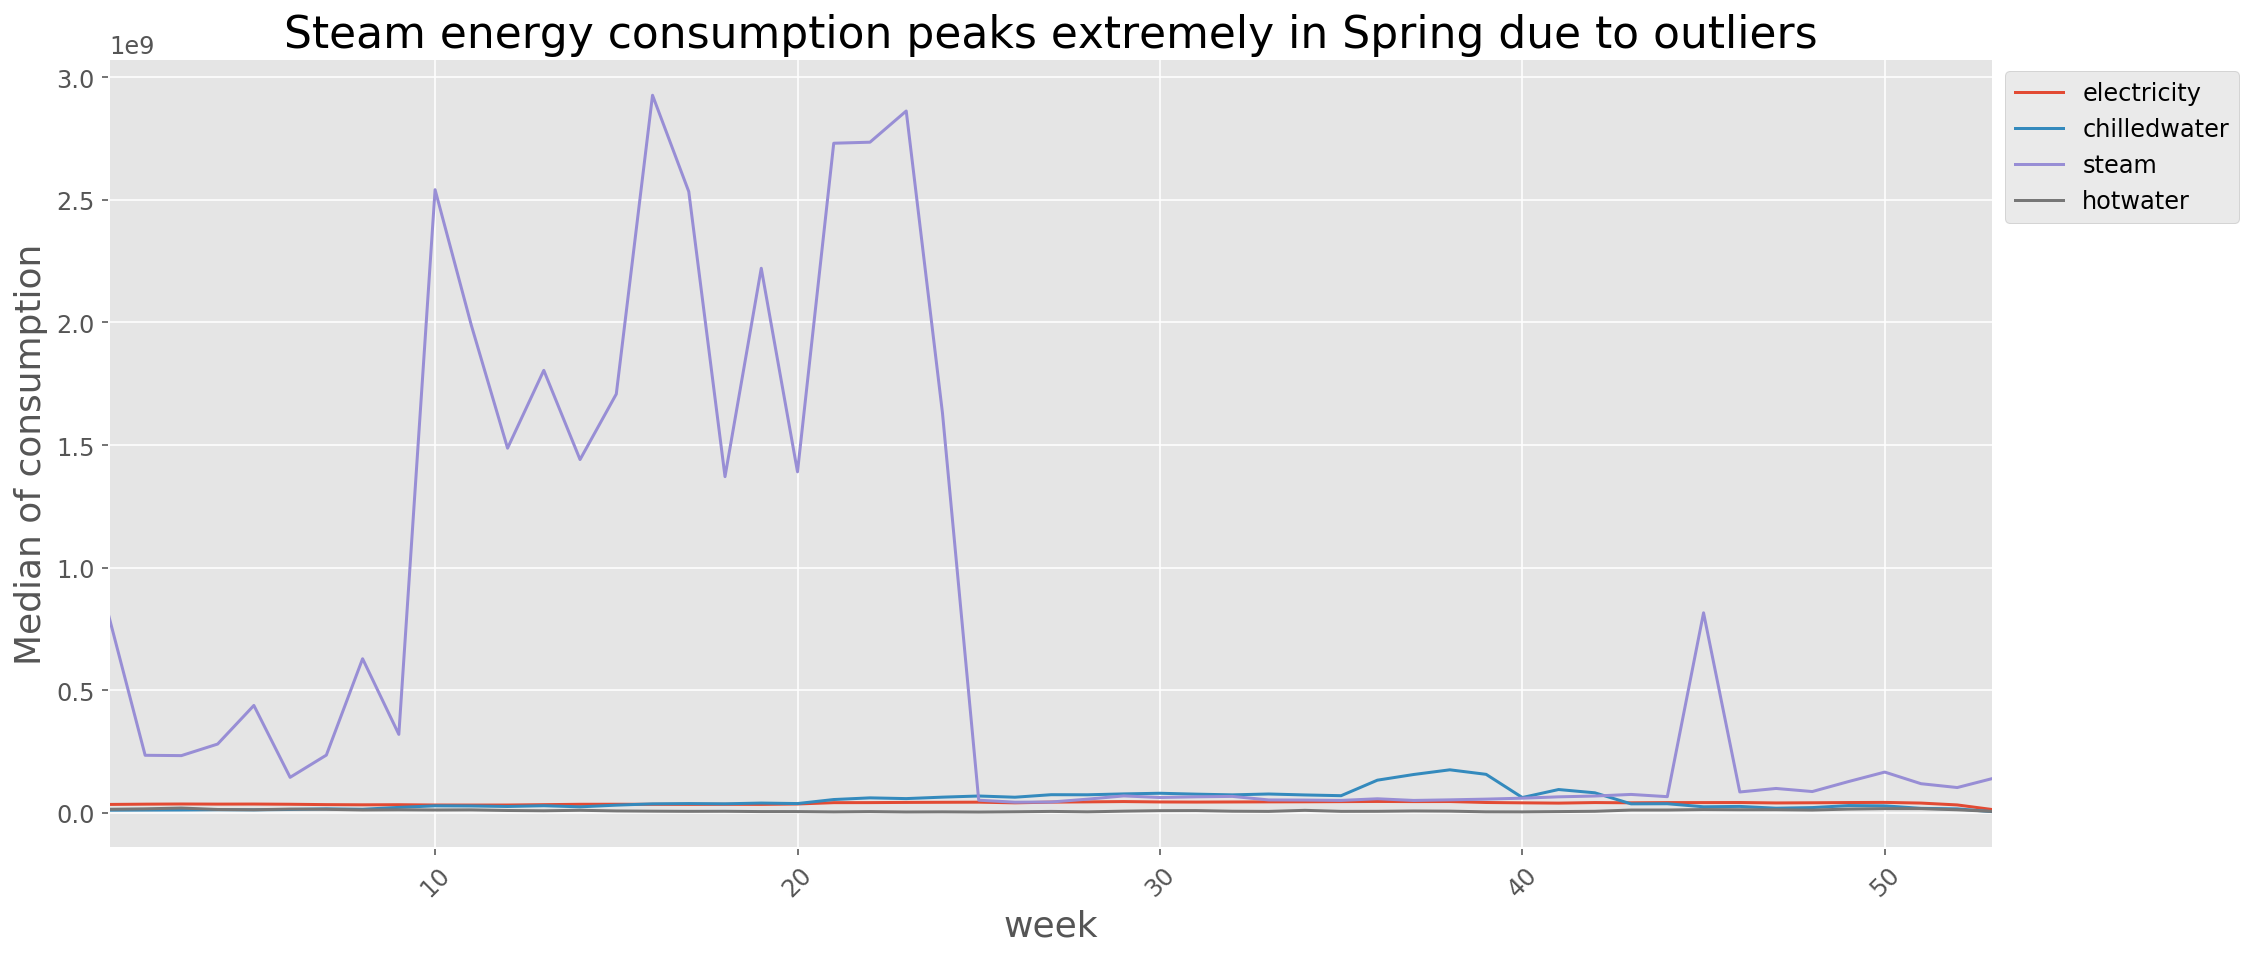

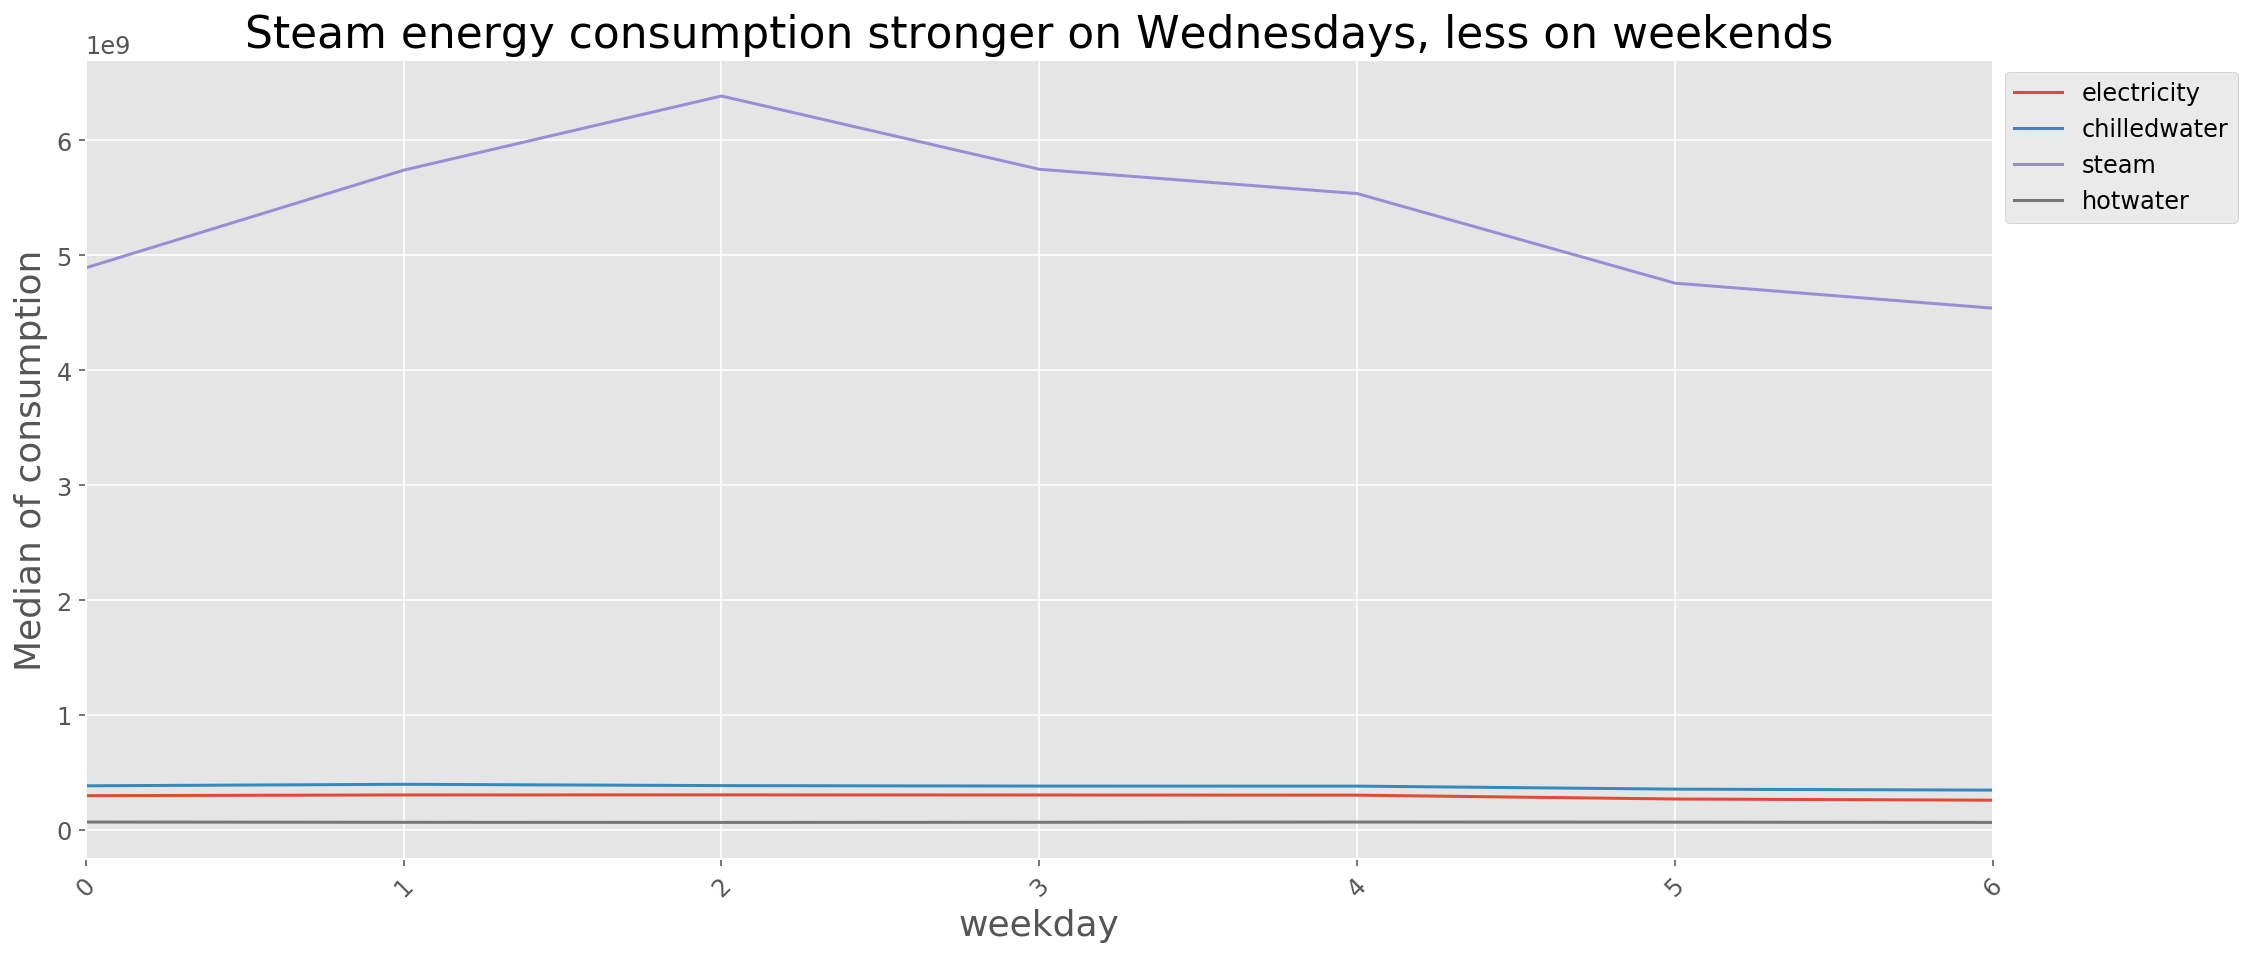

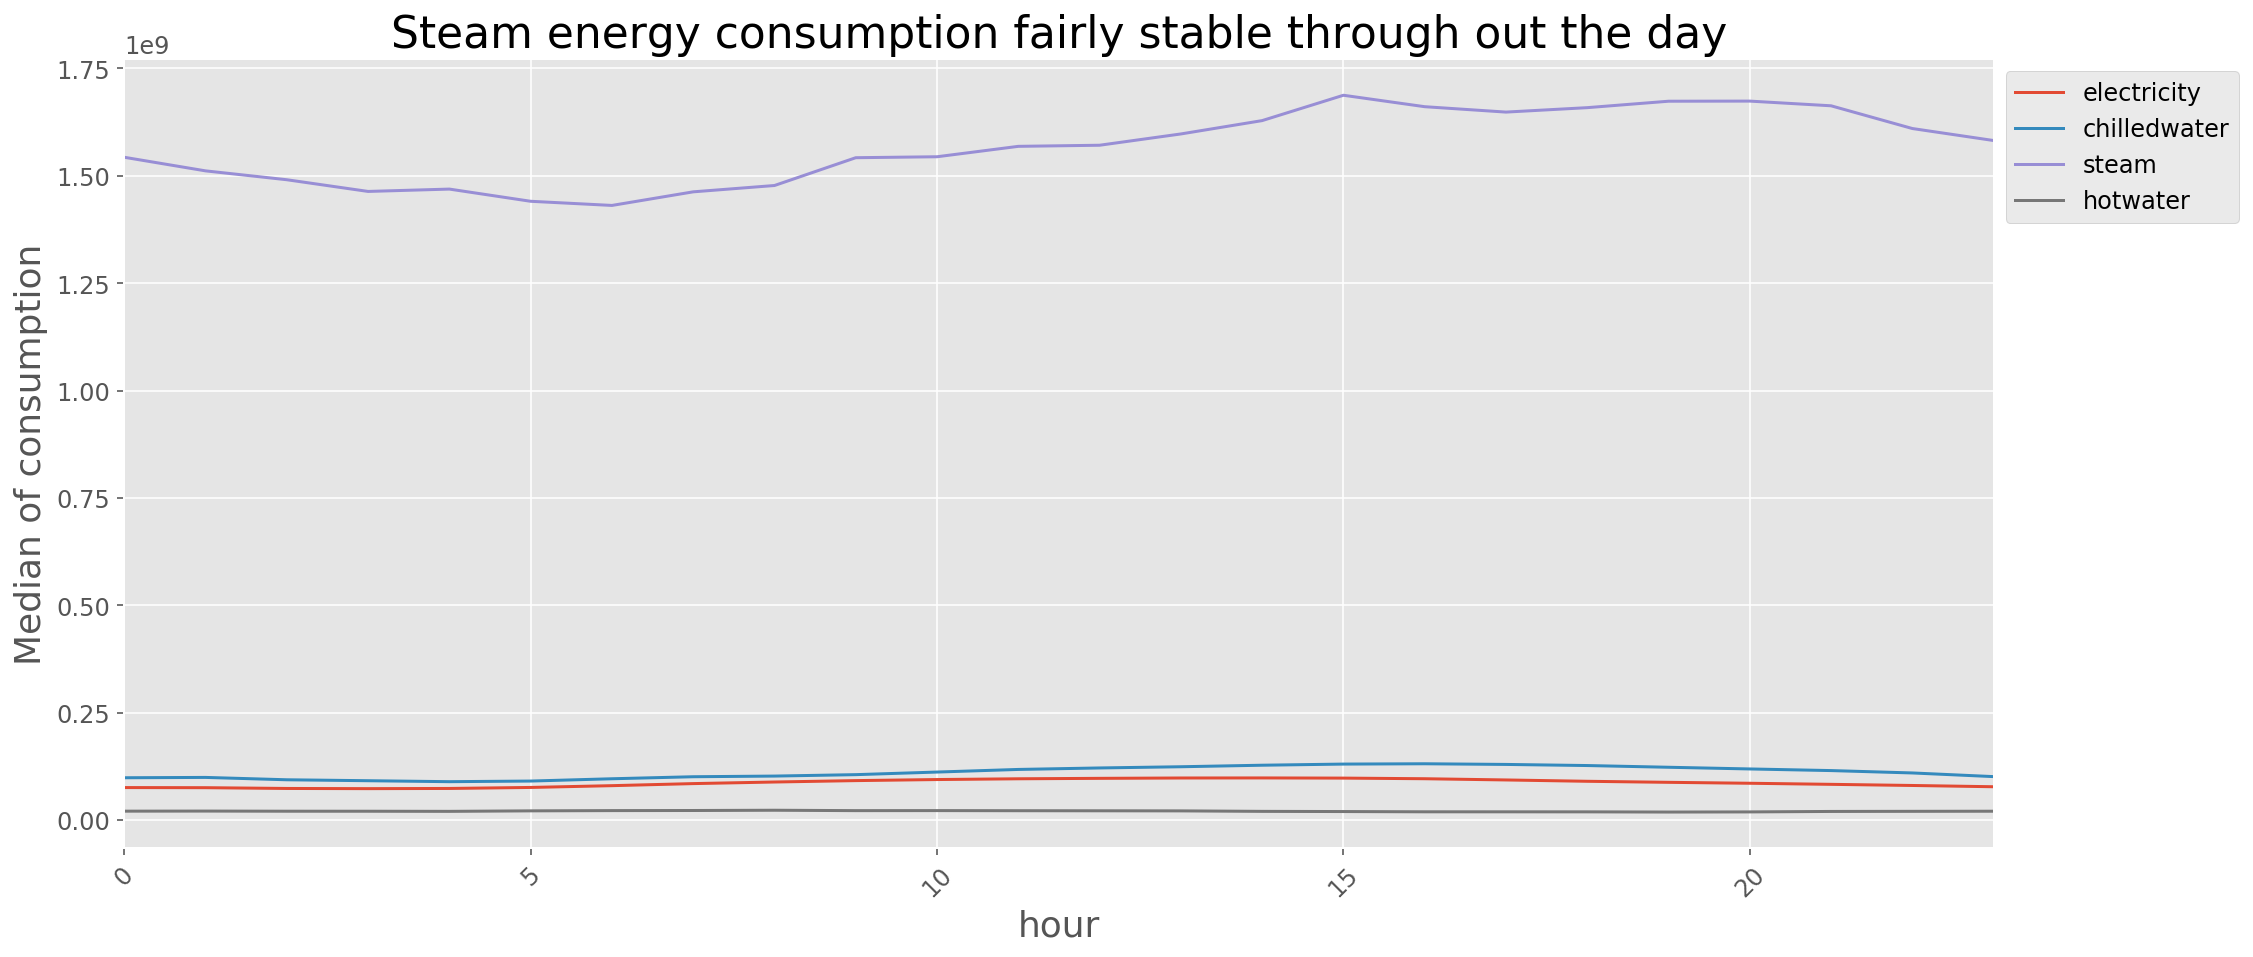

In [0]:
## Steam consumption
for timeframe_name, timeframe in timeframes.items():
    plt.figure(figsize=(16,7))
    for idx in range(0,4):
        tmp_df = train_df[train_df.meter==idx].groupby(timeframe).meter_reading.sum()
        tmp_df.plot(kind="line", label=energy_types[idx], use_index=True)
    plt.xticks(rotation=45)
    plt.ylabel("Median of consumption")
    plt.xlabel(f"{timeframe_name}")
    plt.title(f"Steam energy consumption fairly stable through out the day")
    
    if timeframe_name in ["month", "week"]:
        plt.title(f"Steam energy consumption peaks extremely in Spring due to outliers")
    if timeframe_name in ["weekday"]:
        plt.title(f"Steam energy consumption stronger on Wednesdays, less on weekends")
    
    plt.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.tight_layout()
    plt.show()

In [0]:
## Outliers
cut_off  = train_df["meter_reading"].std() * 3
lower    = train_df["meter_reading"].mean() - cut_off 
upper    = train_df["meter_reading"].mean() + cut_off
df_lower = train_df[train_df["meter_reading"] < lower]
df_upper = train_df[train_df["meter_reading"] > upper]
    
if df_lower.shape[0] != 0 or df_upper.shape[0] != 0:
    print(f"{'meter_reading'}")
    print(f"lower bound: {lower:.2f}\nupper bound: {upper:.2f}")
if df_lower.shape[0] != 0:
        display(train_df[train_df["meter_reading"] < lower].sort_values("meter_reading"))
if df_upper.shape[0] != 0:
        display(train_df[train_df["meter_reading"] > upper].sort_values("meter_reading"))

display(df_upper.building_id.value_counts())
display(df_upper.meter.value_counts())

meter_reading
lower bound: -457589.75
upper bound: 461824.00


Unnamed: 0  building_id  ...  timestampSecond timestampElapsed
14531339    14531339          778  ...                0       1474480800
16078422    16078422          778  ...                0       1476846000
15947163    15947163          778  ...                0       1476644400
15599395    15599395          778  ...                0       1476111600
14983126    14983126          778  ...                0       1475172000
...              ...          ...  ...              ...              ...
8905140      8905140         1099  ...                0       1465804800
17286421    17286421         1099  ...                0       1478700000
8736187      8736187         1099  ...                0       1465545600
8738539      8738539         1099  ...                0       1465549200
8907488      8907488         1099  ...                0       1465808400

[3750 rows x 33 columns]

1099    3159
778      591
Name: building_id, dtype: int64

2    3159
1     591
Name: meter, dtype: int64